### Maxwell A. Fine 14880725
### Assingment 3: Stastical Methods in Astrophysics

Note to marker:
* heavy use of tutorial code for parts 2, 3, 4
* due to new functions needed, I recreate them each time instead of adding key flag args 
* I use chat gpt to assit in writing function doc strings 


In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.stats import pearsonr, spearmanr
from itertools import combinations # fancy nested for loop
from scipy.stats import norm
from scipy.stats import lognorm
import scipy.stats as sps
import scipy.integrate as spint
import scipy.integrate as spint
import scipy.interpolate as spinterp
from scipy.integrate import simps
from uncertainties import ufloat
from scipy.optimize import curve_fit
from lmfit import Model, Minimizer, Parameters, report_fit
import numpy as np
import lmfit 
import emcee
import corner
from multiprocess import Pool
import scipy as scipy

# Constants 
G = 6.67e-11 # SI
parsec_to_m = 3.086e+16 # how many km are in 1 ps
mass_sun_kg = 1.989e30 #kg

# Set a seed for reproducibility
random_seed = 50

# Gaia correction term
gaia_corr = 0.029 # mas

assigned_clusters = [ 'NGC_6611', 'NGC_1817', 'NGC_663',]
#assigned_clusters = ['lessi_43', 'UFMG_2', 'Ruprecht_171']

# Gaia correction term
gaia_corr = 0.029 # mas


# Task 1:
First, make stellar density profiles for each of your three clusters. To do this, you first need to create a
new column in your dataframe which contains the radial separation of each star (in arcseconds) from
the centre of its cluster, i.e. � = 3600. '(� − �̅)! + (� − �/)! where � and � are the RA and DE
positions of the star (in degrees) and �̅and �/ are the means of RA and DE for all the stars in the
cluster (i.e. the estimated location of the centre of the cluster). 

Then, use the radial locations of the
stars to make a histogram of stellar number density �∗ vs. radius, that is, the number of stars in a
radial bin, normalized by the area of the radial bin, which will correspond to an annulus on the sky
(use arcsec2 as the units of area). Choose appropriate radial binning and plot the stellar density
profiles (and error bars, if appropriate) for your 3 clusters on separate plots.

### Idea & Assumptions:

* Calculate mean Ra, Dec and add them as new collums in the stars_df for each cluster. IE all stars from the same cluster have the same mean ra and mean dec. I will then use mean RA, mean Dec to calculate radial seperation
* data is IID, this is reasnobly as we expect each star is independent, and clusters should follow some profile
* I will bin the data, and then rebin the data to ensure that there are 20 counts min per bin
    - I assume each data bin will act like a Poisson distrubution, and then rebining to this threshold lets me apply the CTL theorum to treat them as normal
* I will convert the bins into stellar density by dividing by the area of each bin / ring
* X errors will be the 1/2 width of the bins 
* Y errors will be np.sqrt(counts) / width



In [2]:
# Load in Data
# This time I am using _df to indicate it is a pandas df
dr3stars = fits.open('gaiadr3_cluster_stars.fits')
dr3stars.info()
#print(dr3stars[1].columns)
stars_df = pd.DataFrame(dr3stars[1].data)
stars_df['Name'] = stars_df['Name'].str.strip()
clcounts = stars_df.groupby(['Name']).size().reset_index(name='count') 


# Lets calculate Mean Ra, Dec for the clusters and add it as a Col in the df
stars_df['cluster_mean_RAdeg'] = stars_df.groupby('Name')['RAdeg'].transform('mean')
stars_df['cluster_mean_DEdeg'] = stars_df.groupby('Name')['DEdeg'].transform('mean')

# Lets compute radial dinstance (in deg) of each star from the estimated cluster center (the means) and add it as a Col 
# Double check this works as intended 
stars_df['radial_separation_arcsec'] = 3600 * np.sqrt((stars_df['RAdeg'] - stars_df['cluster_mean_RAdeg'])**2
                                    + (stars_df['DEdeg'] - stars_df['cluster_mean_DEdeg'])**2)  # 3600 is the conversion factor 


# Mean Proper motion
# Quadrature sum of RA and dec to calculate proper motion
stars_df['abs_proper_motion'] = np.sqrt((stars_df['pmRA'] )**2
                                    + (stars_df['pmDE'] )**2) 


# grab assigned star clusters
assigned_clusters_df = stars_df[stars_df['Name'].isin(assigned_clusters)]


Filename: gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   


In [3]:
def histrebin(mininbin,counts,edges):
    '''Takes as input a minimum counts per bin and a histogram counts and bin edges, and combines 
       adjacent histogram bins as needed so that no bin has less than the required minimum.
       Inputs:
           mininbin - required minimum counts/bin.
           counts, edges - input histogram counts/bin and bin edges arrays.
       Outputs:
           counts2, edges2 - rebinned counts/bin and bin edges arrays'''
    edges2=np.zeros(1)  
    counts2=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges2[0]=edges[0]
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts2[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts2=np.append(counts2,countsum)
            edges2=np.append(edges2,edges[i])
            countsum=0        
    return counts2, edges2

In [4]:
# I feel like we are going to be plotting this a bunch so lets make a function 
def stellar_density_profile_plot(stars_df, cluster_name, nbins=50, minibin=20):
    '''
    Plot the stellar density profile for a given star cluster.

    Parameters:
    - stars_df (DataFrame): DataFrame containing information about stars, including 'Name' and 'radial_separation_arcsec'.
    - cluster_name (str): Name of the star cluster for which the stellar density profile will be plotted.
    - nbins (int): Number of bins for the histogram (default is 50).
    - minibin (int): Number of sub-bins for rebinning the data (default is 20).

    Returns:
    - None: Displays a plot of the stellar density profile.'''

    source_distance = stars_df[stars_df['Name'] == cluster_name]['radial_separation_arcsec'] # arcsec

    hist, bins = np.histogram(source_distance, bins=nbins)  # Adjust the number of bins as needed
                                                                                      # Using SQRT of n rule for the moment
    
    # rebin the data 
    hist, bins = histrebin(mininbin=minibin,counts=hist,edges=bins)

    # Compute bin centers, convert into stellar density 
    bin_centers = (bins[:-1] + bins[1:]) / 2
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2) 
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area
    # calculate bin widths 
    bin_width = np.diff(bins)

    # Plotting
    fig = plt.figure(figsize=(14, 6), dpi=300)
    # Step plot to look like a histogram
    plt.scatter((bin_centers), stellar_density, alpha=0.4, color='teal',label='Data',zorder=1)
    plt.step(bin_centers, stellar_density, where='mid', color='teal', linewidth=1, alpha=0.4, zorder=1)
    plt.errorbar(bin_centers, stellar_density, yerr=std_stellar_den, xerr=bin_width/2, fmt='none', ecolor='teal', capsize=3, alpha=0.4)
    plt.title(cluster_name + ' N = '+ str(len(source_distance)) + '\nStellar Density Profile', size=15)
    plt.xlabel('Distance From Center (mas)', size=15)
    plt.ylabel('Sources Per (mas$^{-2}$)', size=15)
    plt.xscale('log')
    plt.yscale('log')
    plt.tick_params(axis='both', which='both', labelsize=12)
    plt.legend()
    plt.show()  


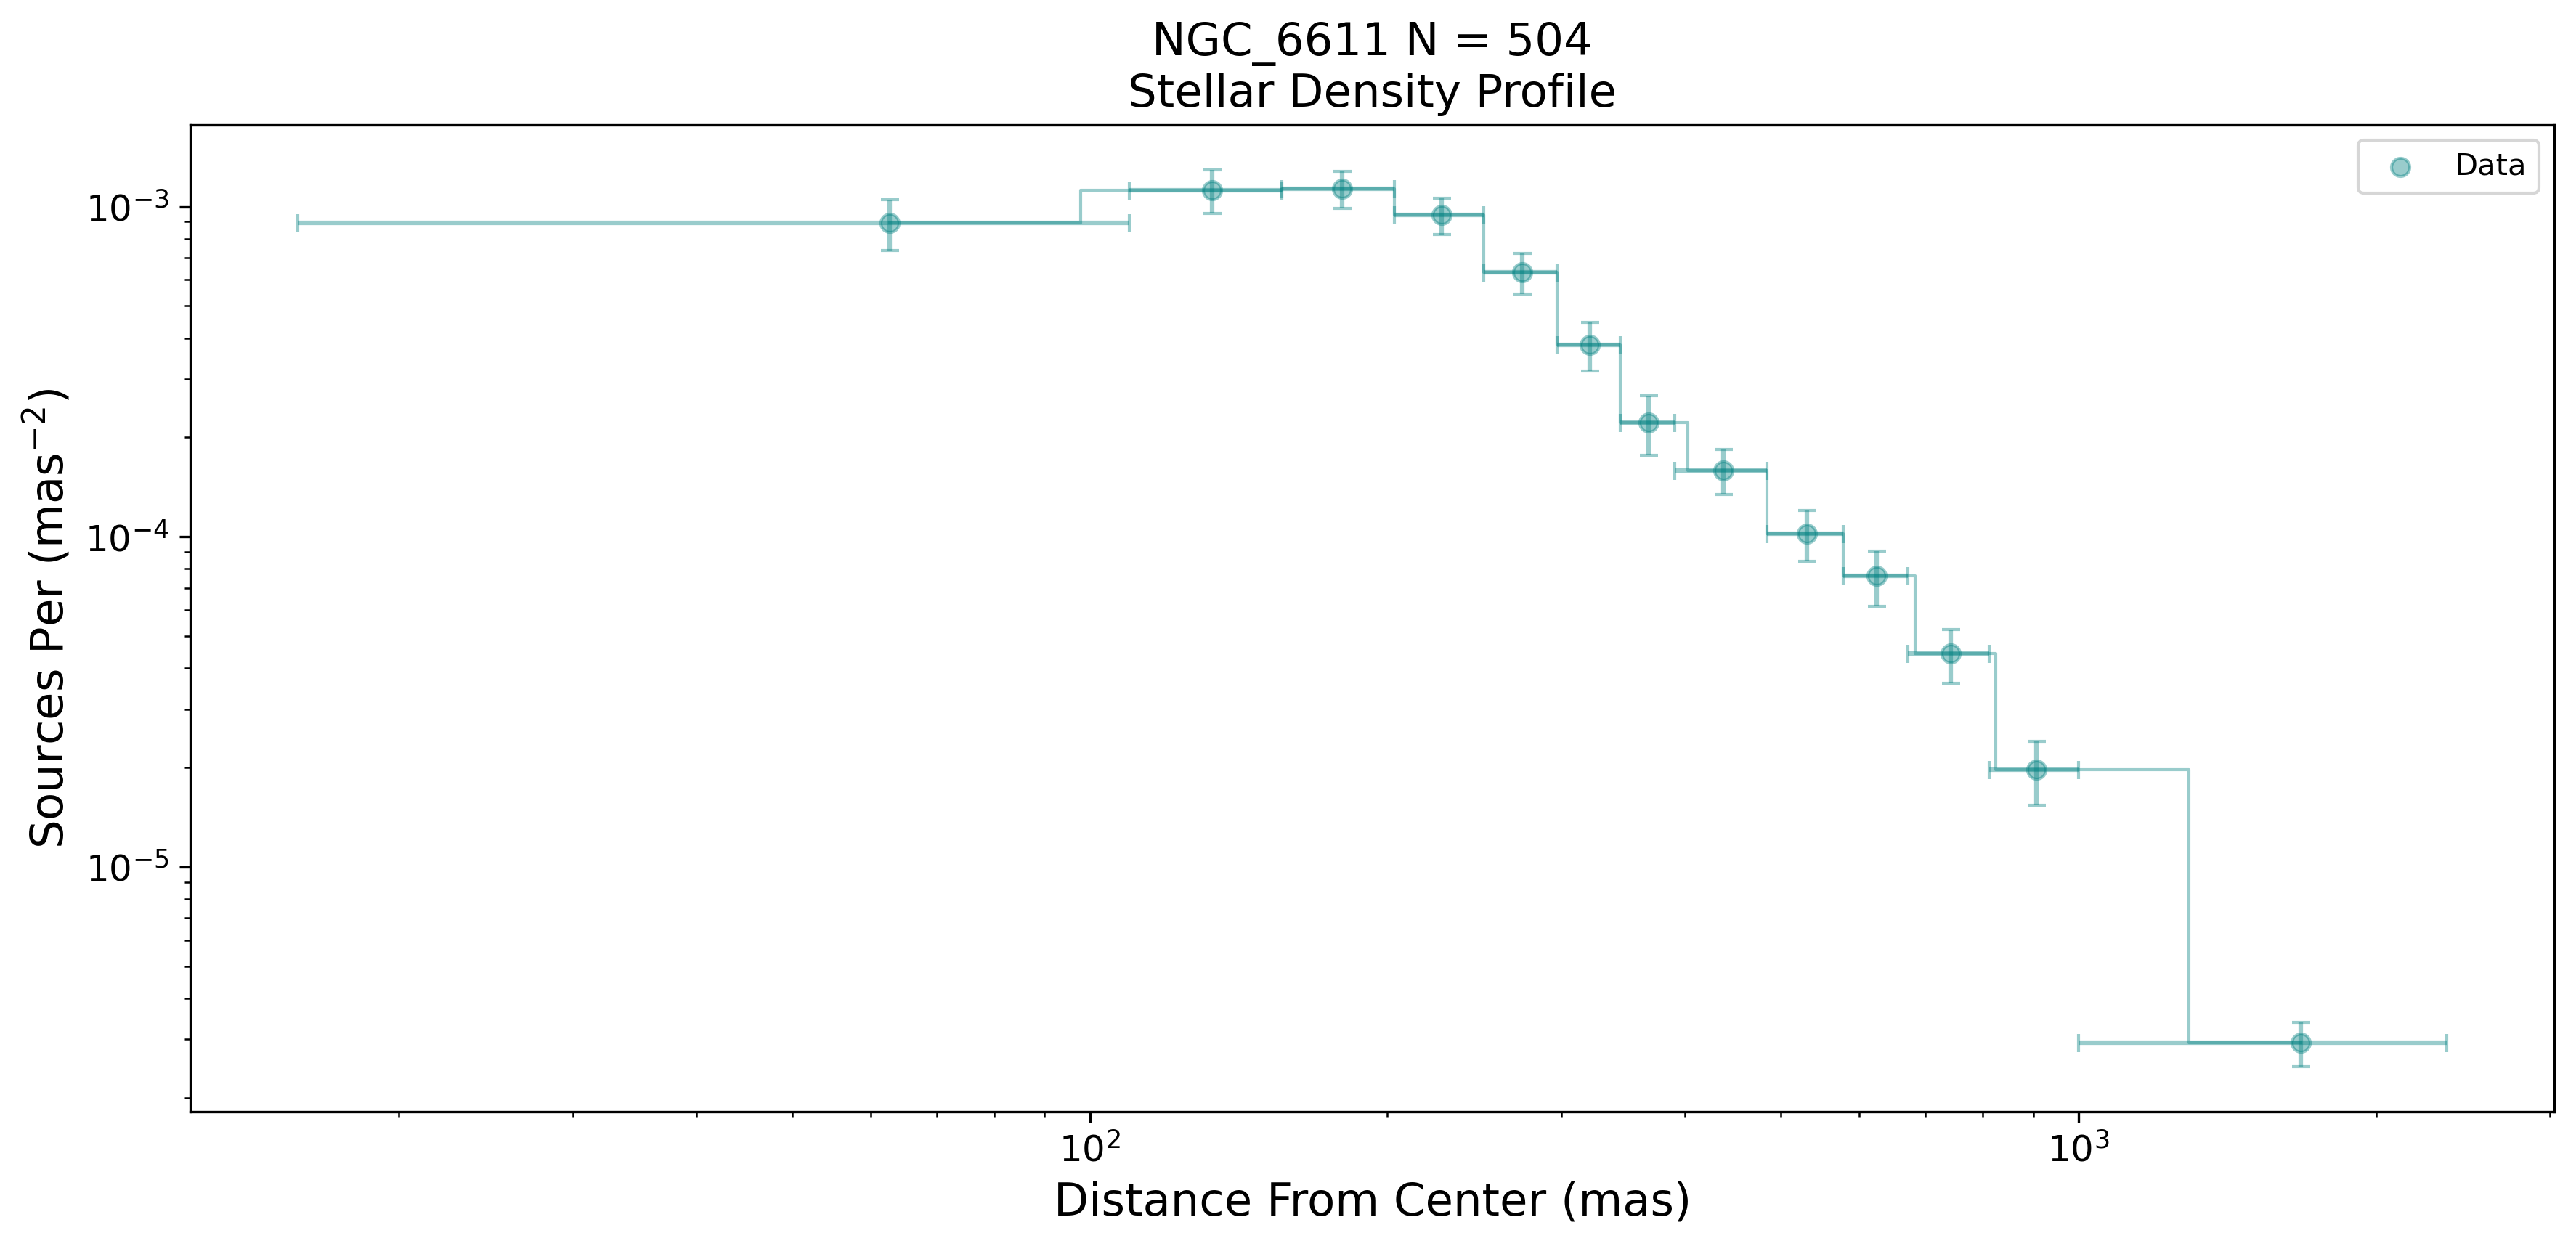

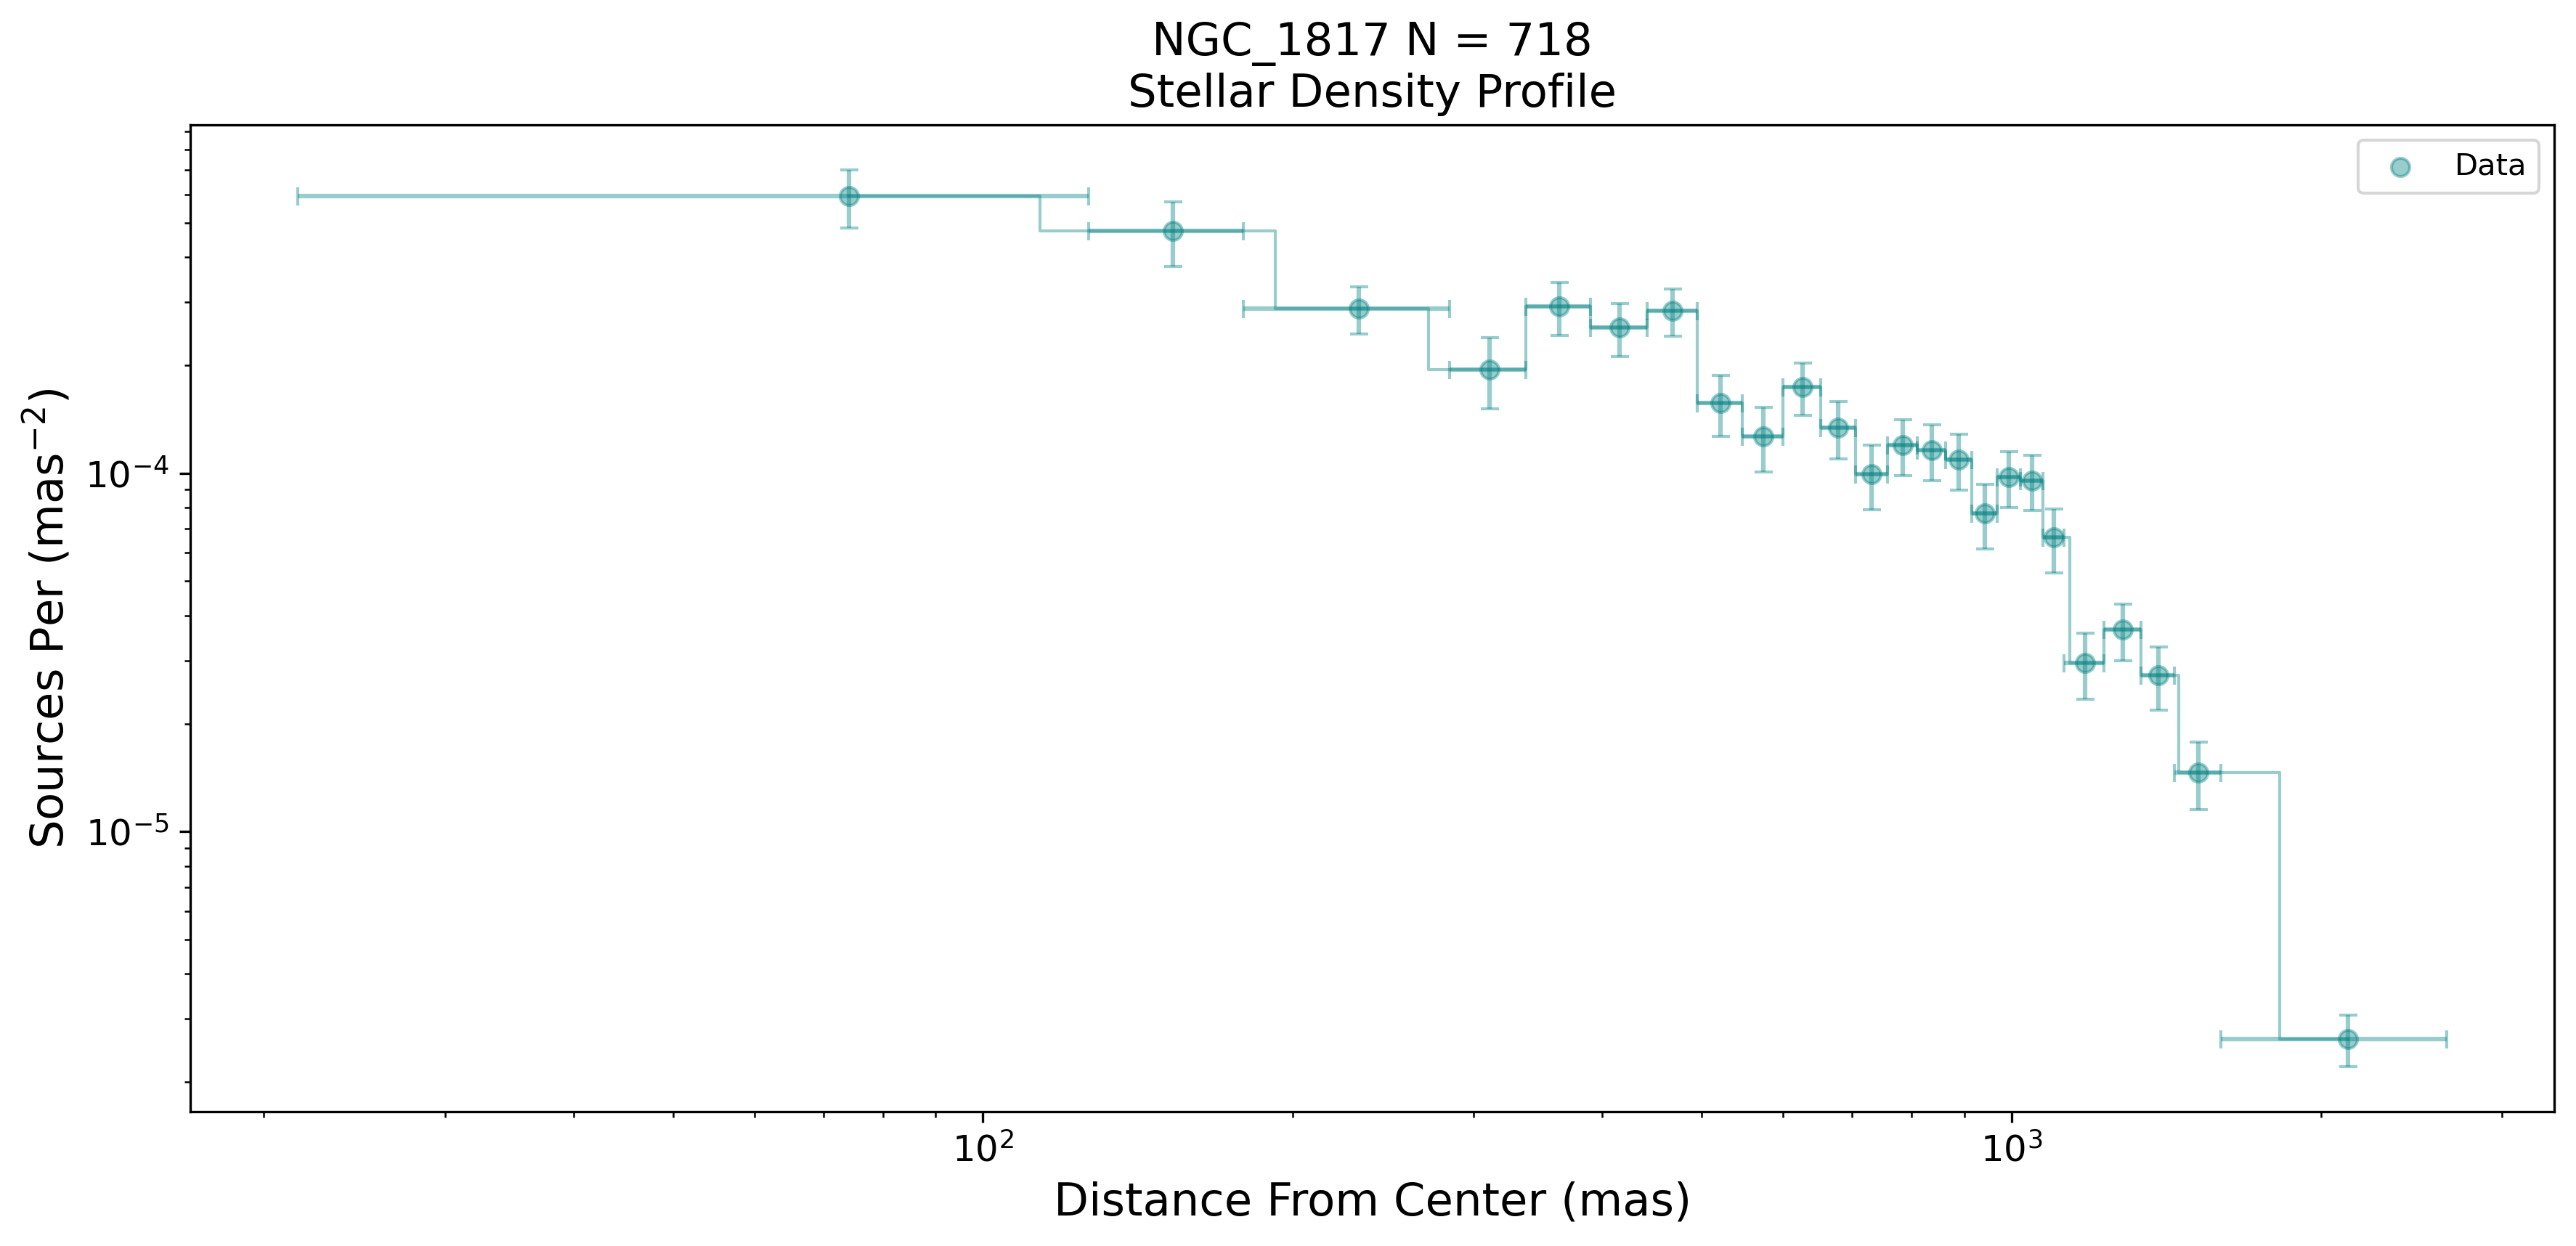

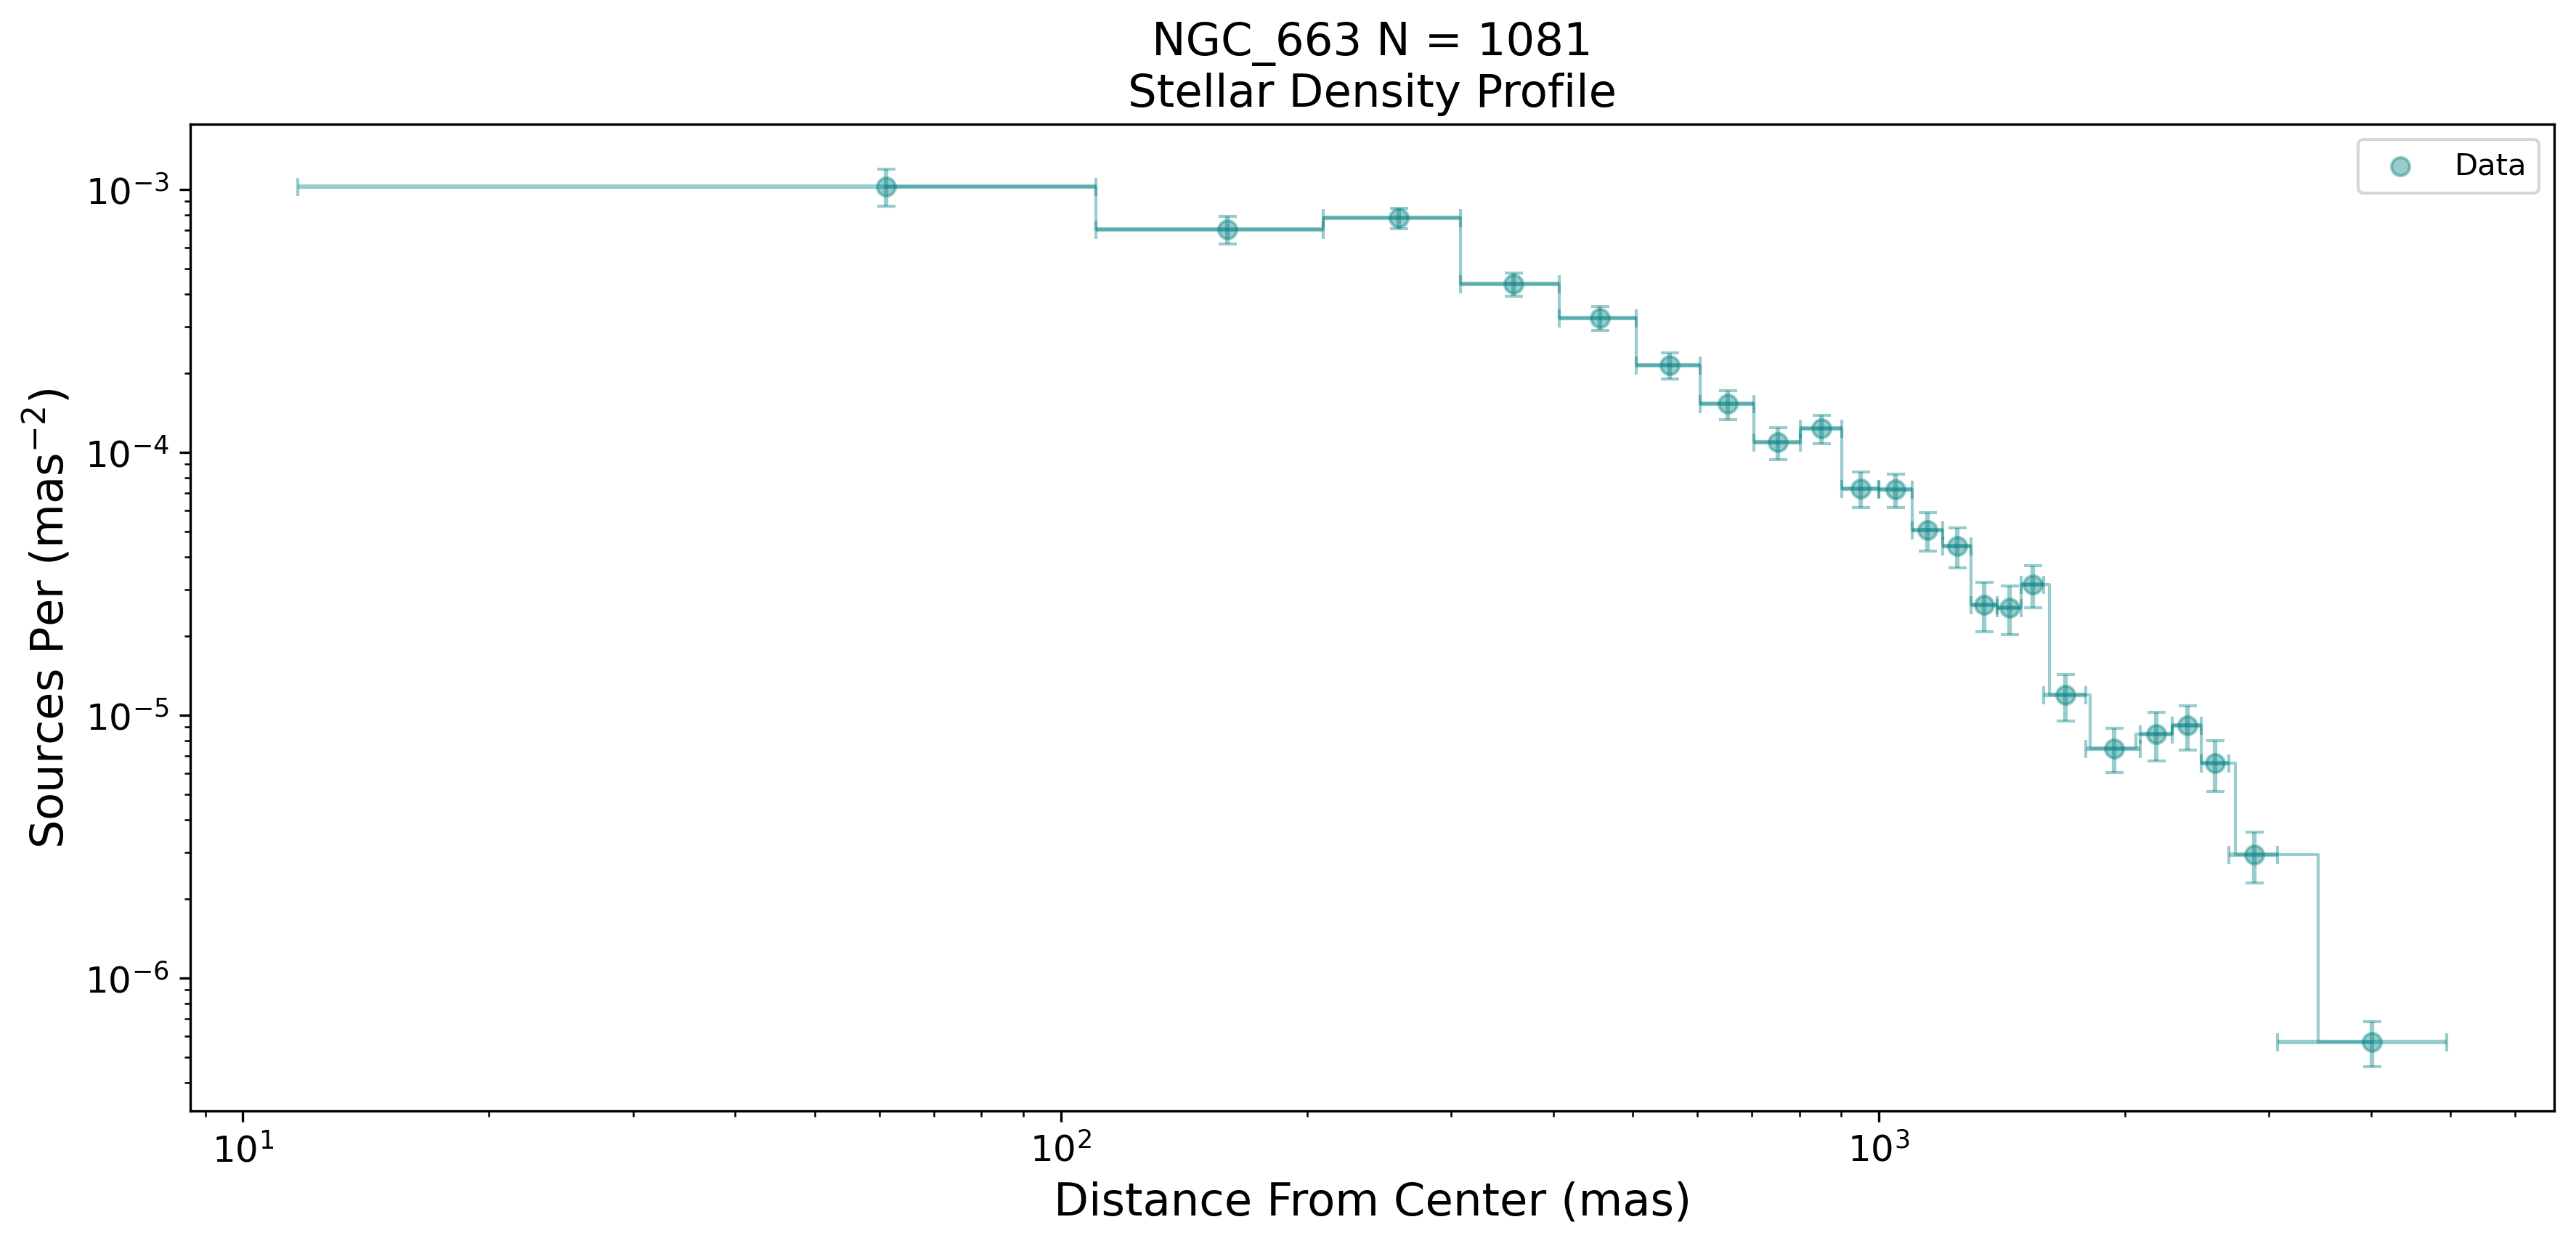

In [5]:
# loop through and plot
for cluster_name in assigned_clusters:
    stellar_density_profile_plot(stars_df, cluster_name)

### 1 Comment:

For my clusters, the data seems to be smooth, and perhaps there is a general 'stellar density model' that all the clusters will fit to. 

# 2 Task:

Fit the King model to the stellar density profiles of your three clusters to obtain the MLEs for the
parameters and a goodness of fit of the model where appropriate. Plot your data again with the
model fits and residuals or ratios as appropriate.

Obtain 1-sigma confidence intervals on the model parameters, and if the intervals are not closed (i.e. they
include the bounds of the fitted parameters, or zero or infinity), obtain 3-� upper or lower (as
appropriate) limits on the parameters.

Kind Model

$$ \rho(r) = \rho_{0} [\frac{1}{\sqrt{1 + (r/r_{c})^2}} - \frac{1}{\sqrt{1 + (r_t/r_{c})^2}}]^2 + c $$

Where $r< r_c$

where for $r > r_t$, $\rho(r) = c$

Here, �' is a normalization factor, �0 is known as the core radius of the cluster, �/ is the tidal radius
(where the cluster is truncated), and � is a constant which corresponds to the number density of
unassociated foreground/background stars (which may be very small for these data, since the cluster
stars have already been pre-selected based on association in astrometric parameter space). 



* use  lmfit




### Idea:
* We modify our existing plotting function, maybe write a a function to do the fiting and confidence intervals 
* Define king model as its own function
* we will use the lm fit package, and follow (like a paint by numbers the tutorial)
* we will need to modify the model_bin function so it integrates the bin-ring area, and not the bin width. 
* we will use min values for the parameters of 0, to insure that fitted params are postive - this is physically motivated
* We will follow along the tutorial guide fo calculating 1-sigma, and 3-sigma errors 

### Assumptions:
* each bin acts as a poission distrubution, rebinning to 20 will let us apply normal distrubution stats and hence enable us to use least square fitting IE lm fit. 

### Model fitting hypothsis garb:
* Lets go with a 3, and 5 sigma signifigance for the model fitting
    - if the model fits within 3 sigma, its a good fit
    - if more then 3, but less then 5, a marginal fit - perhaps bad cluster or yada yada, we are using **all** stars, not just those with high prob so possibily low prob stars will throw off model 
    - if greater then 5 sigma, bad fit 

* The null hypothesis, is that the model fits


In [6]:
#### copy and paste from lesson  with little modification

def model_bin(xbins, model, params):
    '''General function for integrating the input model over bins defined by contiguous (no gaps) 
        bin edges, xbins.
       Inputs:
           xbins - x bin edges.
           model, params - the model name and associated Parameters object.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(xbins)-1)
    bins =xbins # egdes 
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers = bin_centers
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  
    for i, xval in enumerate(xbins[:-1]):
        ymod[i], ymoderr = spint.quad(lambda x: 2*np.pi *x * model(x, params),xbins[i],xbins[i+1])
        #ymod[i] = ymod[i]/((xbins[i+1]-xbins[i])) 
        ymod[i] = ymod[i] / annulus_area[i] # we now divide by the bin width to match the counts density
        # units of our data
    return ymod

def lmf_lsq_binresid(params,xdata,ydata,yerrs,model,output_resid=True):
    '''lmfit objective function to calculate and return residual array or model y-values for
        binned data where the xdata are the input bin edges and ydata are the densities (integral over bin
        divided by bin width).
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
        Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)'''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
            if i == 0:
                resid = (ydata[i]-model_bin(xdata[i],model,params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model_bin(xdata[i],model,params))/yerrs[i])
        return resid
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel



In [7]:
def king_model(x, params):
    '''
    King model for stellar density profile.

    Parameters:
    - x (float or array-like): Radial distance values for which the stellar density profile is calculated.
    - params (dict): Dictionary containing the King model parameters.
        - 'rho_knot' (float): Central stellar density.
        - 'c' (float): Background stellar density.
        - 'r_c' (float): Core radius.
        - 'r_t' (float): Tidal radius.

    Returns:
    - rho_king (float or array-like): Stellar density profile values corresponding to the input radial distances.

    The King model describes the stellar density profile of a star cluster as a function of radial distance from the center.
    The function takes the radial distances 'x' and a dictionary of parameters 'params' including 'rho_knot' (central density),
    'c' (background density), 'r_c' (core radius), and 'r_t' (tidal radius). It calculates the stellar density profile
    according to the King model formula, and if 'rho_king' is a NumPy array, it sets values to 'c' for radial distances
    greater than 'r_t' using boolean indexing.

    Note: All parameters must be numeric (int or float), and an error is raised if any parameter is non-numeric.
    '''
    r = x
    
    param_values = {}
    for param_name in params.keys():
        param_values[param_name] = params[param_name].value if isinstance(params[param_name], lmfit.Parameter) else params[param_name]

    # Now, you can access individual parameter values using param_values dictionary
    rho_knot = param_values['rho_knot']
    c = param_values['c']
    r_c = param_values['r_c']
    r_t = param_values['r_t']
        
    # Check if all parameters are numeric
    if not all(isinstance(param, (int, float)) for param in [rho_knot, c, r_c, r_t]):
        print('error in function')
        raise ValueError("All parameters must be numeric.")
    
    # Perform calculations
    frac1 = 1 / np.sqrt(1 + (r / r_c)**2)
    frac2 = 1 / np.sqrt(1 + (r_t / r_c)**2)
    rho_king = rho_knot * (frac1 - frac2)**2 + c
    
    # Use boolean indexing to set values for r > r_t if rho_king is a NumPy array
    if isinstance(rho_king, np.ndarray):
        rho_king[r > r_t] = c

    else:
        if r > r_t:
            rho_king = c
    
    return rho_king


In [8]:
def fit_and_plot_king(stars_df, cluster_name, print_output= True, plot=True):
    '''
    Fit and plot the King model for the stellar density profile of a star cluster.

    Parameters:
    - stars_df (DataFrame): DataFrame containing information about stars, including 'Name' and 'radial_separation_arcsec'.
    - cluster_name (str): Name of the star cluster for which the King model will be fitted and plotted.
    - print_output (bool): If True, print fitting results and statistics (default is True).
    - plot (bool): If True, generate and display a plot of the fitting results (default is True).

    Returns:
    - result (lmfit.MinimizerResult): Result of the least-squares minimization.
    - xdata (array-like): Radial distances used for fitting.
    - ydata (array-like): Stellar density values used for fitting.
    - yerrs (array-like): Errors in stellar density values used for fitting.

    This function fits the King model to the stellar density profile of a star cluster and optionally prints the fitting
    results and generates a plot. It uses the Levenberg-Marquardt algorithm for least-squares minimization. The function
    returns the fitting result, along with the data used for fitting.

    Note: The King model parameters are hard-coded within the function. If custom initial guesses or bounds are desired,
    the function should be modified accordingly.
    '''

    nbins = 50
    source_distance = stars_df[stars_df['Name'] == cluster_name]['radial_separation_arcsec'] # arcsec

    hist, bins = np.histogram(source_distance, bins=nbins, range=[0,np.max(source_distance)])  # Adjust the number of bins as needed
                                                                                        # Using SQRT of n rule for the moment
        
    # rebin the data 
    hist, bins = histrebin(mininbin=20,counts=hist,edges=bins)


    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers = bin_centers
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  # this is wrong?
    #annulus_area = np.pi * np.diff(bins)**2
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area
    bin_width = np.diff(bins)
    # For convience 
    x_data = bins
    y_data = stellar_density
    y_data_errors = std_stellar_den
    x_data_errors = bin_width/2


    # all together now
    model = king_model
    output_resid = True

    # set params
    # set params
    param_guess = {'rho_knot': 1, 'c': 1e-5, 'r_c': 500, 'r_t': 1000}
    params = Parameters()
    params.add_many(('rho_knot', 1), ('c', 1e-5), ('r_c', 500), ('r_t', 1000))

    # Define parameter bounds
    param_bounds = {'rho_knot': (0, np.inf), 'c': (1e-12, 1e-4), 'r_c': (0, np.inf), 'r_t': (0, np.inf)}

    # Create Parameters with bounds
    params = lmfit.Parameters()
    for param_name, param_value in param_guess.items():
        bounds = param_bounds.get(param_name, (-np.inf, np.inf))
        params.add(param_name, value=param_value, min=bounds[0], max=bounds[1])



    xdata = [bins]
    ydata = [stellar_density]
    yerrs = [std_stellar_den]
    set_function = Minimizer(lmf_lsq_binresid, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
    result = set_function.minimize(method = 'leastsq')

    if print_output:
        report_fit(result)
        print("Minimum Chi-squared = "+str(result.chisqr)+" for "+str(result.nfree)+" d.o.f.")
        print("The goodness of fit is: ",sps.chi2.sf(result.chisqr,df=result.nfree))


    #### plot stuff

    if plot:
        # Extracting the best-fit parameters
        best_fit_params = result.params.valuesdict()

        # Generate x values for the model plot
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14,6), sharex=True, gridspec_kw={'height_ratios': [2, 1]}, dpi=300)

        x_data = bin_centers
        ax1.scatter(x_data, y_data, label='Data', color='teal',alpha=0.7)
        ax1.errorbar(bin_centers, stellar_density, yerr=std_stellar_den, xerr=x_data_errors, fmt='none', ecolor='teal', capsize=3, alpha=0.7)
        x_model = x_data
        ax1.step(x_data, king_model(x_data, best_fit_params), label='King Model', where='mid', linewidth=1.5, color='firebrick',alpha=0.7,)

        ax1.set_ylabel('Sources Per (mas$^{-2}$)', size=12)
        ax1.tick_params(axis='both', which='both', labelsize=12)
        ax1.legend(fontsize=12)
        ax1.set_yscale('log')
        ax1.set_xscale('log')

        # Plot residuals in the second subplot
        residuals = y_data - king_model(x_data, best_fit_params)
        # Data ratio 
        #ax2.scatter(x_data, result.best_fit/ y_data, label='Residuals', color='k', alpha=0.5)
        ax2.errorbar(x_data, y_data / king_model(x_data, best_fit_params), fmt='none', yerr = y_data_errors/y_data, 
                     label='Residuals', color='k', alpha=0.5, capsize=3,)
        ax2.scatter(x_data, y_data / king_model(x_data, best_fit_params), color='k', alpha=0.5, )
        ax2.axhline(1, color='black', linestyle='--', linewidth=1)
        ax2.set_xlabel('Distance From Center (mas)', size=12)
        ax2.set_ylabel('Data / Model', size=12)
        ax2.tick_params(axis='both', which='both', labelsize=12)

        # Plot garb
        plt.suptitle(cluster_name + ' N = '+ str(len(source_distance)) + '\nStellar Density Profile', size=12)
        plt.savefig(cluster_name +'_model_fit', bbox_inches='tight')
        plt.show()
    
    # now switch back for the vars we used for model fitting 
    xdata = x_data
    ydata = y_data
    yerrs = y_data_errors #std_stellar_den
    return result, xdata,ydata,yerrs

In [9]:
def lmf_lsq_resid(params,xdata,ydata,yerrs,model,output_resid=True):
    '''lmfit objective function to calculate and return residual array or model y-values.
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1, n2 respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
        Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)'''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
            if i == 0:
                resid = (ydata[i]-model(xdata[i],params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model(xdata[i],params))/yerrs[i])
        return resid
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model(xdata[i],params))
        return ymodel

def calc_error_chisq(delchisq,a_best,minchisq,a_grid,chisq_grid):
    '''Function to return upper and lower values of a parameter 'a' for a given delta-chi-squared
       Input:
           delchisq - the delta-chi-squared for the confidence interval required (e.g. 1 for 1-sigma error)
           a_best, minchisq - best-fitting value for 'a' and corresponding chi-squared minimum
           a_grid, chisq_grid - grid of 'a' and corresponding chi-squared values used for interpolation'''
    # First interpolate over the grid for values > a_best and find upper interval bound
    chisq_interp_upper = spinterp.interp1d(chisq_grid[a_grid > a_best],a_grid[a_grid > a_best])
    a_upper = chisq_interp_upper(minchisq+delchisq)
    # Interpolate for values <= a_best to find lower interval bound
    chisq_interp_lower = spinterp.interp1d(chisq_grid[a_grid <= a_best],a_grid[a_grid <= a_best])
    a_lower = chisq_interp_lower(minchisq+delchisq)  
    return [a_lower,a_upper]


def grid1d_chisqmin(a_name,a_range,a_steps,parm,model,xdata,ydata,yerrs):
    '''Uses lmfit. Finds best the fit and then carries out chisq minimisation for a 1D grid of fixed 
       parameters.
       Input: 
            a_name - string, name of 'a' parameter (in input Parameters object parm) to use for grid.
            a_range, a_steps - range (tuple or list) and number of steps for grid.
            parm - lmfit Parameters object for model to be fitted.
            model - name of model function to be fitted.
            xdata, ydata, yerrs - lists of data x, y and y-error arrays (as for the lmf_lsq_resid function)
        Output: 
            a_best - best-fitting value for 'a'
            minchisq - minimum chi-squared (for a_best)
            a_grid - grid of 'a' values used to obtain fits
            chisq_grid - grid of chi-squared values corresponding to a_grid'''
    a_grid = np.linspace(a_range[0],a_range[1],a_steps)
    chisq_grid = np.zeros(len(a_grid))
    # First obtain best-fitting value for 'a' and corresponding chi-squared
    set_function = Minimizer(lmf_lsq_resid, parm, fcn_args=(xdata, ydata, yerrs, model, True),
                             nan_policy='omit')
    result = set_function.minimize(method = 'leastsq')
    minchisq = result.chisqr
    a_best = result.params.valuesdict()[a_name]
    # Now fit for each 'a' in the grid, to do so we use the .add() method for the Parameters object
    # to replace the value of a_name with the value for the grid, setting vary=False to freeze it
    # so it cannot vary in the fit (only the other parameters will be left to vary)
    for i, a_val in enumerate(a_grid):
        parm.add(a_name,value=a_val,vary=False)
        set_function = Minimizer(lmf_lsq_resid, parm, fcn_args=(xdata, ydata, yerrs, model, True), 
                                                                nan_policy='omit')
        result = set_function.minimize(method = 'leastsq')
        chisq_grid[i] = result.chisqr
    return a_best, minchisq, a_grid, chisq_grid 



def calc_error_chisq(delchisq, a_best, minchisq, a_grid, chisq_grid):
    # Upper bound
    upper_mask = a_grid > a_best
    if np.any(upper_mask) and (minchisq + delchisq <= max(chisq_grid[upper_mask])):
        chisq_interp_upper = spinterp.interp1d(chisq_grid[upper_mask], a_grid[upper_mask])
        a_upper = chisq_interp_upper(minchisq + delchisq)
    else:
        a_upper = None  # Interval extends beyond grid range

    # Lower bound
    lower_mask = a_grid <= a_best
    if np.any(lower_mask) and (minchisq + delchisq <= max(chisq_grid[lower_mask])):
        chisq_interp_lower = spinterp.interp1d(chisq_grid[lower_mask], a_grid[lower_mask])
        a_lower = chisq_interp_lower(minchisq + delchisq)
    else:
        a_lower = None  # Interval extends beyond grid range

    return [a_lower, a_upper]


The problem probably arises because the chisqr corresponding to your 1 or 3 sigma interval is higher than the chisqr array in your interval. You could avoid the error by manually checking if your minchisqr + delchisqr is lower than the maximum chisqr in your array, and if not, set the confidence interval to None on that side

In [10]:
# lets make a confidence interval function 

def get_confidence_intervals(result, stars_df, cluster_name, plotting=True, print_output=True):
    '''
    Calculate and plot confidence intervals for the parameters of the King model.

    Parameters:
    - result (lmfit.MinimizerResult): Result of the least-squares minimization obtained from fitting the King model.
    - stars_df (DataFrame): DataFrame containing information about stars, including 'Name' and 'radial_separation_arcsec'.
    - cluster_name (str): Name of the star cluster for which confidence intervals will be calculated and plotted.
    - plotting (bool): If True, generate and display a plot of the confidence intervals (default is True).
    - print_output (bool): If True, print the results of the confidence interval calculations (default is True).

    Returns:
    - a_intervals (dict): Dictionary containing the 1 and 3 sigma confidence intervals for each King model parameter.

    This function calculates and optionally plots the 1 and 3 sigma confidence intervals for the parameters of the King model
    fitted to the stellar density profile of a star cluster. It uses a grid search method and plots the results with dotted
    lines representing the confidence intervals. The function returns a dictionary containing the confidence intervals for each
    parameter.

    Note: The King model parameters are hard-coded within the function. If custom parameter names or bounds are desired,
    the function should be modified accordingly.
    '''

    result = result # need to change for each cluster

    model = king_model
    par_names = ['gam0','E0','N'] # Names of parameters in Parameters object

    param_guess = {'rho_knot': 1, 'c': 1e-5, 'r_c': 500, 'r_t': 1000}
    par_names = list(param_guess.keys())
    n_steps = 100  # Number of steps in our grids
    # Ranges for each parameter - should aim for a few times times 1-sigma error estimated from covariance
    # We can specify by hand or use the values from the original minimize result if available:
    par_ranges = []
    for i, par_name in enumerate(par_names):
        # range min/max are best-fitting value -/+ four times the estimated 1-sigma error from variances 
        # (diagonals of covariance matrix)

        
        par_min = result.params.valuesdict()[par_name] - 6*np.sqrt(result.covar[i,i])
        par_max = result.params.valuesdict()[par_name] + 6*np.sqrt(result.covar[i,i])

        # need to set if statement for bounds
        # we do not want any negative bounds on physicial grounds
        if par_min < 0:
            par_min =0

        par_ranges.append([par_min,par_max])
    #par_ranges = [[109,112],[175,177],[204,206]]   # if specified by hand
    if print_output:
        print("Parameter ranges for grid:",par_ranges)

    # For convenience when plotting we will store our results in arrays, which we now set up:
    a_best = np.zeros(len(par_ranges))
    minchisq = np.zeros(len(par_ranges))
    a_grid = np.zeros((len(par_ranges),n_steps))
    chisq_grid = np.zeros((len(par_ranges),n_steps))
    a_int = np.zeros((len(par_ranges),2))

    # 3 sigma
    a_best3 = np.zeros(len(par_ranges))
    minchisq3 = np.zeros(len(par_ranges))
    a_grid3 = np.zeros((len(par_ranges),n_steps))
    chisq_grid3 = np.zeros((len(par_ranges),n_steps))
    a_int3 = np.zeros((len(par_ranges),2))

    delchisq = 1.0  # For 1-sigma errors for a single parameter 
    delchisq_3sigma = 9 # for 3-sigma errors for a single parameter
                        # I hope

    # 1 sigma
    # Now do the grid calculation for each parameter:
    if print_output:
        print('\n\nMLE with 1 Sigma Erros')
    for i, par_range in enumerate(par_ranges):
        params = Parameters()
        for param_name, param_value in param_guess.items():
            value = result.params.valuesdict()[par_name]
            params.add(param_name, value=value)
        a_best[i], minchisq[i], a_grid[i,:], chisq_grid[i,:] = grid1d_chisqmin(par_names[i],par_range,n_steps,params,model,
                                xdata,ydata,yerrs)
        
        a_int[i,:] = calc_error_chisq(delchisq,a_best[i],minchisq[i],a_grid[i,:],chisq_grid[i,:])
        if print_output:
            print('MLE '+par_names[i]+':',str(a_best[i]),
                'with 1 Sigma errors:',str((a_int[i,:]-a_best[i])))   
            

    # 3 sigma
    # Now do the grid calculation for each parameter:
    if print_output:
        print('\n\nMLE with 3 Sigma Erros')

    for i, par_range in enumerate(par_ranges):
        params = Parameters()
        for param_name, param_value in param_guess.items():
            value = result.params.valuesdict()[par_name]
            params.add(param_name, value=value)
        a_best3[i], minchisq3[i], a_grid3[i,:], chisq_grid3[i,:] = grid1d_chisqmin(par_names[i],par_range,n_steps,params,model,
                                xdata,ydata,yerrs)
        
        a_int3[i,:] = calc_error_chisq(delchisq_3sigma,a_best3[i],minchisq3[i],a_grid3[i,:],chisq_grid3[i,:])
        print('MLE '+par_names[i]+':',str(a_best3[i]),
            'with 3 Sigma errors:',str((a_int3[i,:]-a_best3[i])))

    if plotting:
        # Now plot along with a cross to mark the MLE and dotted lines to show the 1-sigma intervals
        par_xlabels = [r'$\Gamma_{0}$ (MeV)',r'$E_{0}$ (MeV)',r'$N$ (mb)']
        par_xlabels = par_names
        fig, (ax1, ax2, ax3, ax4,) = plt.subplots(1,4, figsize=(12,4), sharey=True, dpi=300)
        fig.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=0.1, hspace=None)
        for i, ax in enumerate([ax1, ax2, ax3, ax4]):
            ax.plot(a_grid[i,:],chisq_grid[i,:],color='#1E88E5')
            ax.scatter(a_best[i],minchisq[i],marker='+',color='#1E88E5')
            ax.vlines(a_int[i,:],ymin=0,ymax=100,color='#004D40',linestyle='dotted', label='1-Sigma')
            ax.vlines(a_int3[i,:],ymin=0,ymax=100,color='#9CF101',linestyle='-.', label='3-Sigma')
            
            ax.set_xlabel(par_xlabels[i],fontsize=12)
            ax.tick_params(axis='both', which='both', labelsize=12)
        ax1.set_ylabel(r'$\chi^{2}$',fontsize=12)
        ax1.set_ylim(np.min(chisq_grid[i,:]),70)


        source_distance = stars_df[stars_df['Name'] == cluster_name]['radial_separation_arcsec'] # arcsec

        plt.suptitle(cluster_name + ' N = '+ str(len(source_distance)) + '\nStellar Density Profile', size=12)
        plt.legend(fontsize=12)
        plt.savefig(cluster_name +'_confidence_interval', bbox_inches='tight')
        plt.show()

    # make a return line here
    # we want to return the 1, and 3 sigma values for the parameters 
    

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 72
    # data points      = 15
    # variables        = 4
    chi-square         = 27.9778878
    reduced chi-square = 2.54344434
    Akaike info crit   = 17.3504641
    Bayesian info crit = 20.1826649
[[Variables]]
    rho_knot:  0.00197059 +/- 2.8785e-04 (14.61%) (init = 1)
    c:         2.1488e-06 +/- 9.1802e-07 (42.72%) (init = 1e-05)
    r_c:       222.940454 +/- 40.8953282 (18.34%) (init = 500)
    r_t:       1525.41868 +/- 289.644420 (18.99%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_c, r_t)      = -0.7385
    C(c, r_t)        = -0.6624
    C(c, r_c)        = +0.4244
    C(rho_knot, r_c) = -0.3897
    C(rho_knot, r_t) = -0.2189
    C(rho_knot, c)   = +0.1782
Minimum Chi-squared = 27.97788776519959 for 11 d.o.f.
The goodness of fit is:  0.0032626855663188837


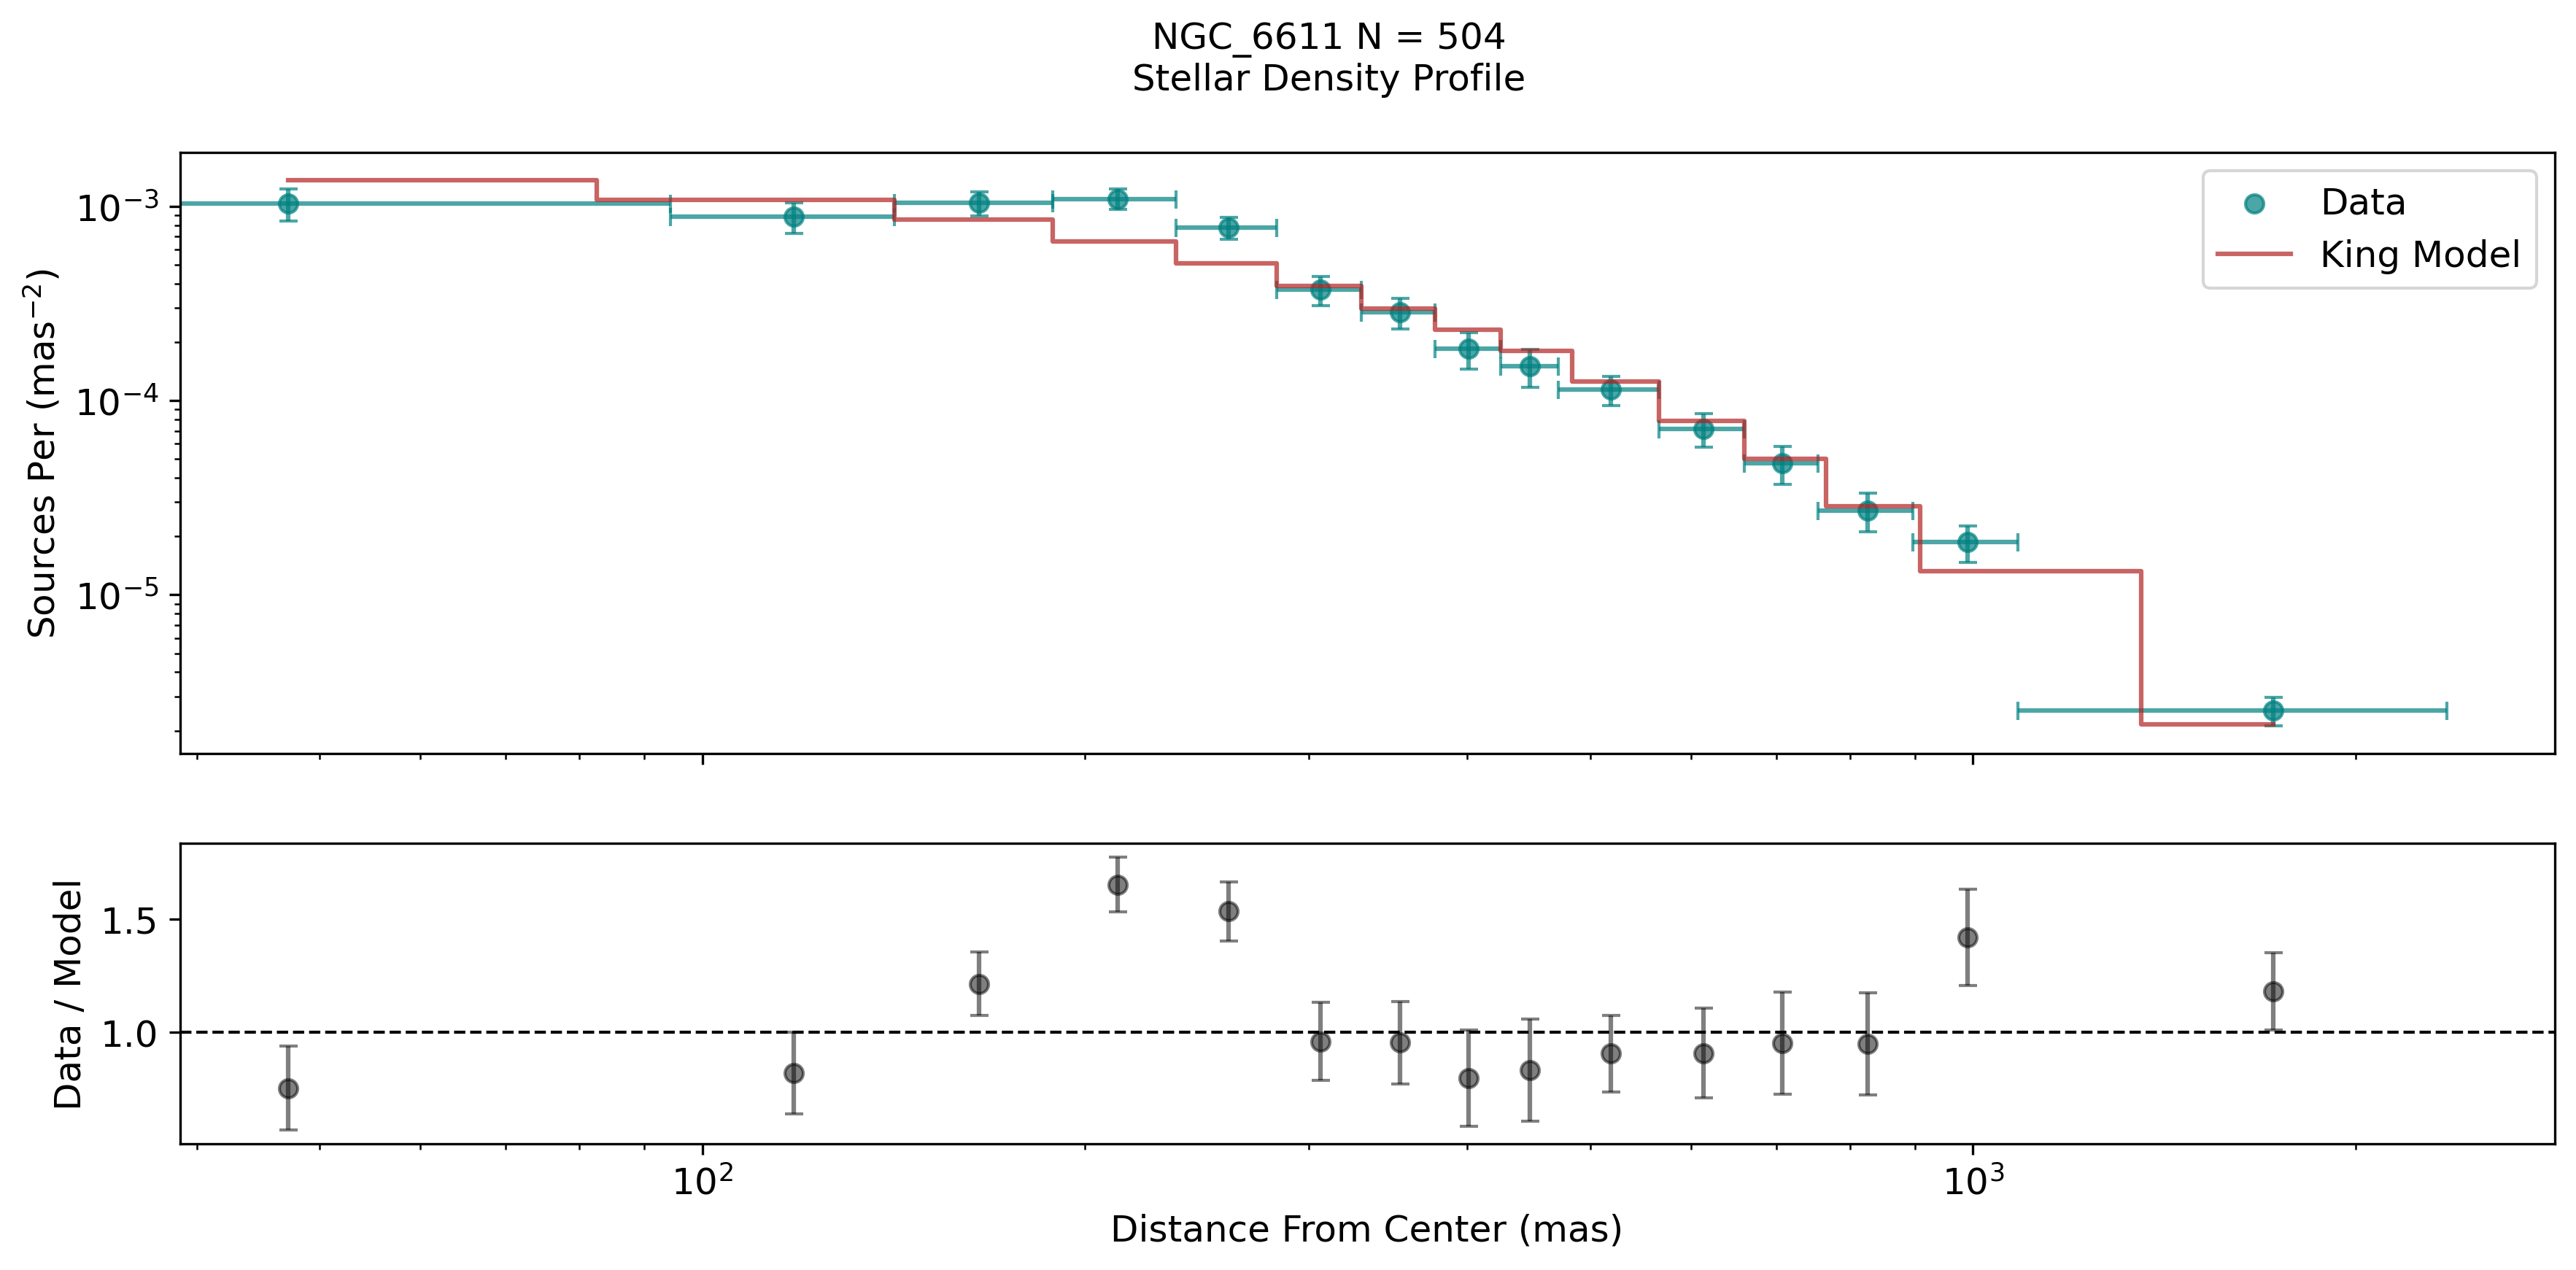

Parameter ranges for grid: [[0.000243509624222125, 0.0036976618180122565], [0, 7.656958799422735e-06], [0, 468.3124226381973], [0, 3263.285198686628]]


MLE with 1 Sigma Erros
MLE rho_knot: 0.0019229206742763462 with 1 Sigma errors: [-0.00016462  0.00017129]
MLE c: 2.5687579233791453e-06 with 1 Sigma errors: [-4.27703918e-07  4.27891755e-07]
MLE r_c: 228.32973630881128 with 1 Sigma errors: [-20.2927112   22.68067035]
MLE r_t: 1513.1668764121334 with 1 Sigma errors: [-141.0868463   182.36190548]


MLE with 3 Sigma Erros
MLE rho_knot: 0.0019229206742763462 with 3 Sigma errors: [-0.00047903  0.00053232]
MLE c: 2.5687579233791453e-06 with 3 Sigma errors: [-2.02596565e-06  1.28737252e-06]
MLE r_c: 228.32973630881128 with 3 Sigma errors: [-55.64630233  78.24848192]
MLE r_t: 1513.1668764121334 with 3 Sigma errors: [-360.23320536  941.3963339 ]


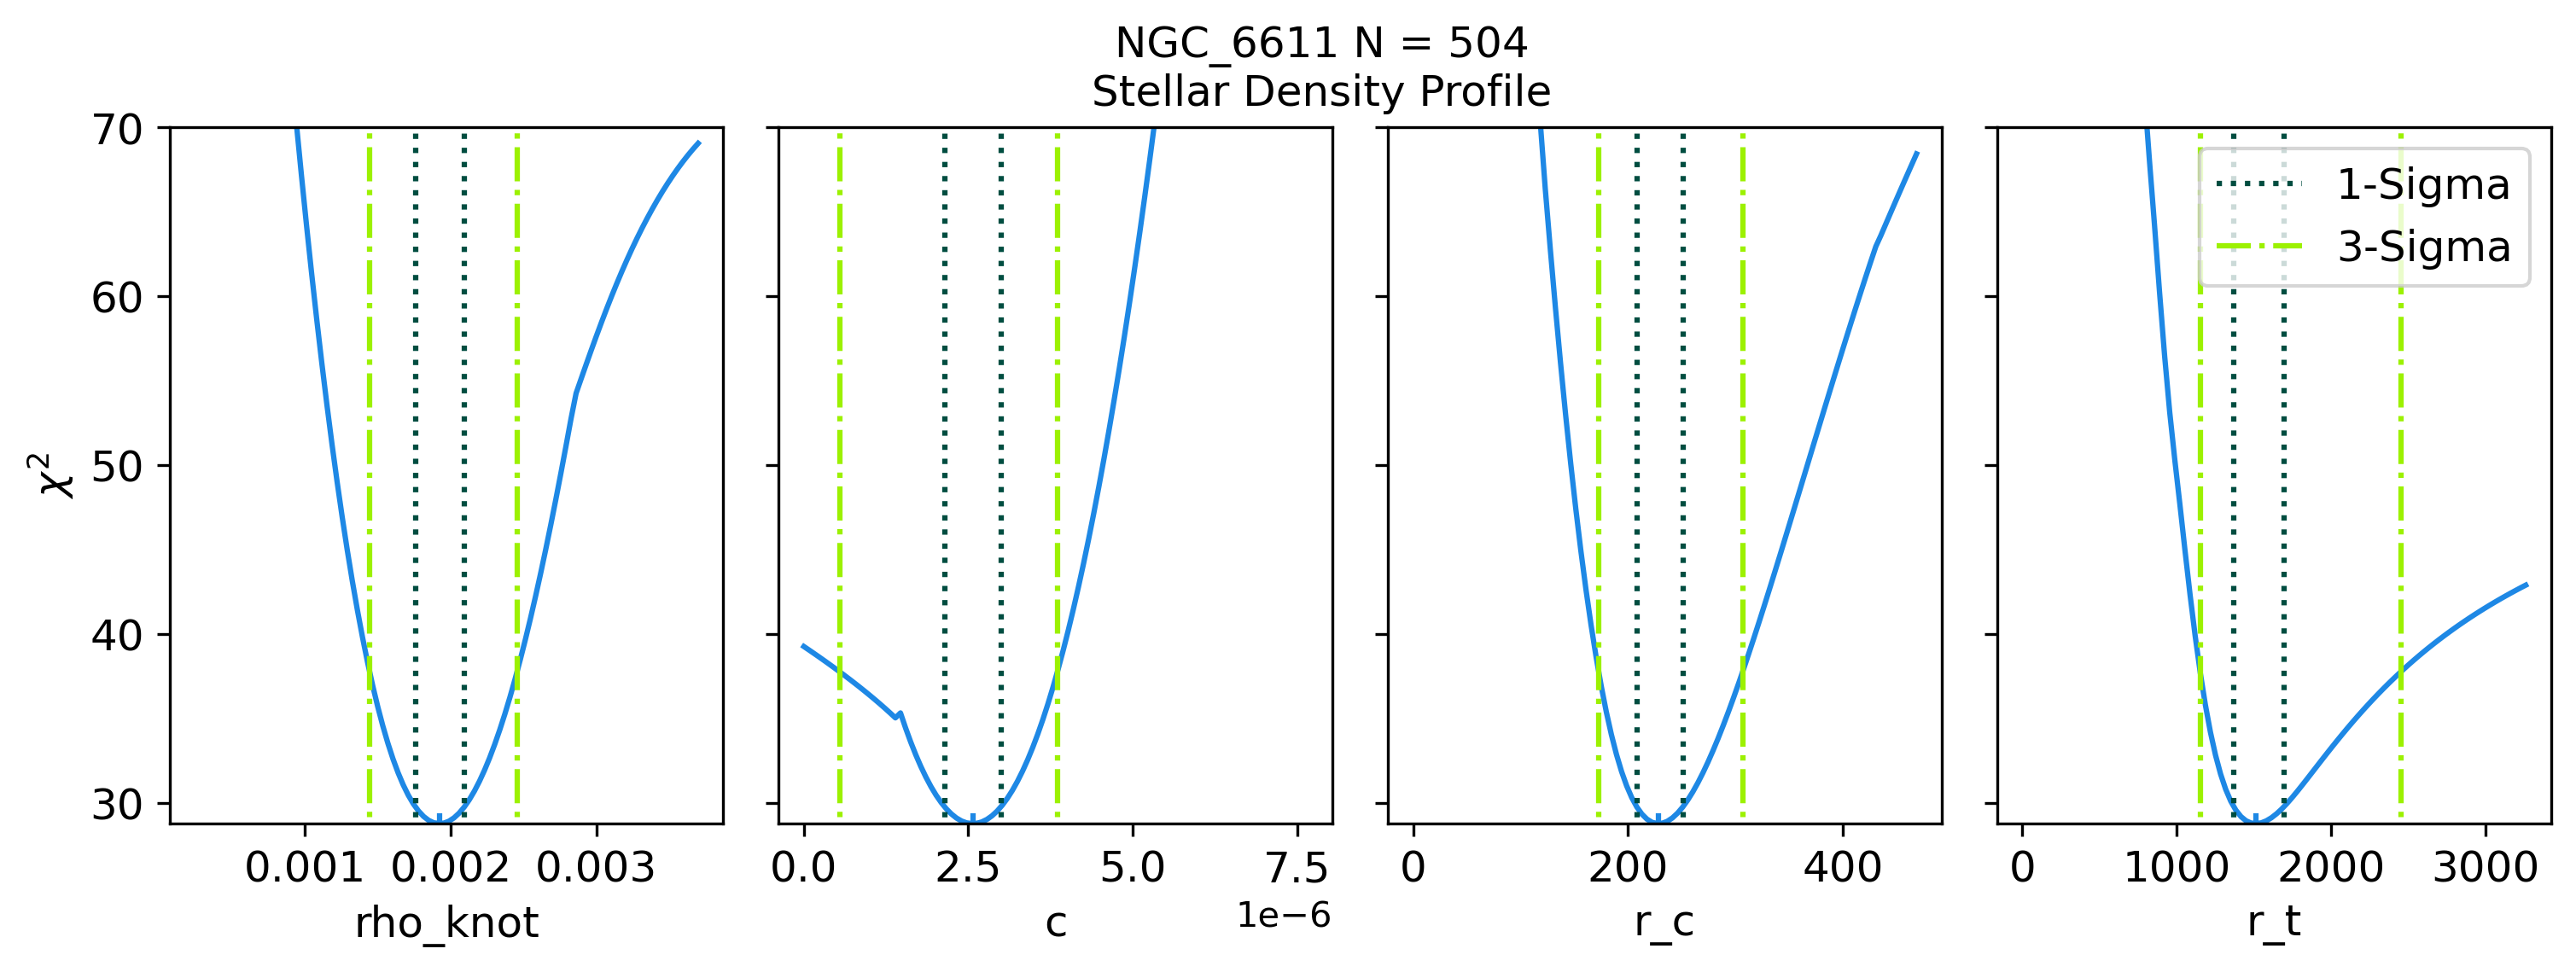

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 24
    # variables        = 4
    chi-square         = 28.5392366
    reduced chi-square = 1.42696183
    Akaike info crit   = 12.1574248
    Bayesian info crit = 16.8696401
[[Variables]]
    rho_knot:  7.6055e-04 +/- 1.8116e-04 (23.82%) (init = 1)
    c:         8.6519e-07 +/- 1.7713e-06 (204.73%) (init = 1e-05)
    r_c:       810.998692 +/- 163.774513 (20.19%) (init = 500)
    r_t:       2314.53197 +/- 385.029191 (16.64%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_knot, r_t) = -0.9786
    C(c, r_t)        = -0.9410
    C(rho_knot, c)   = +0.9045
    C(r_c, r_t)      = -0.8866
    C(rho_knot, r_c) = +0.8606
    C(c, r_c)        = +0.7671
Minimum Chi-squared = 28.539236587519163 for 20 d.o.f.
The goodness of fit is:  0.0972363741595679


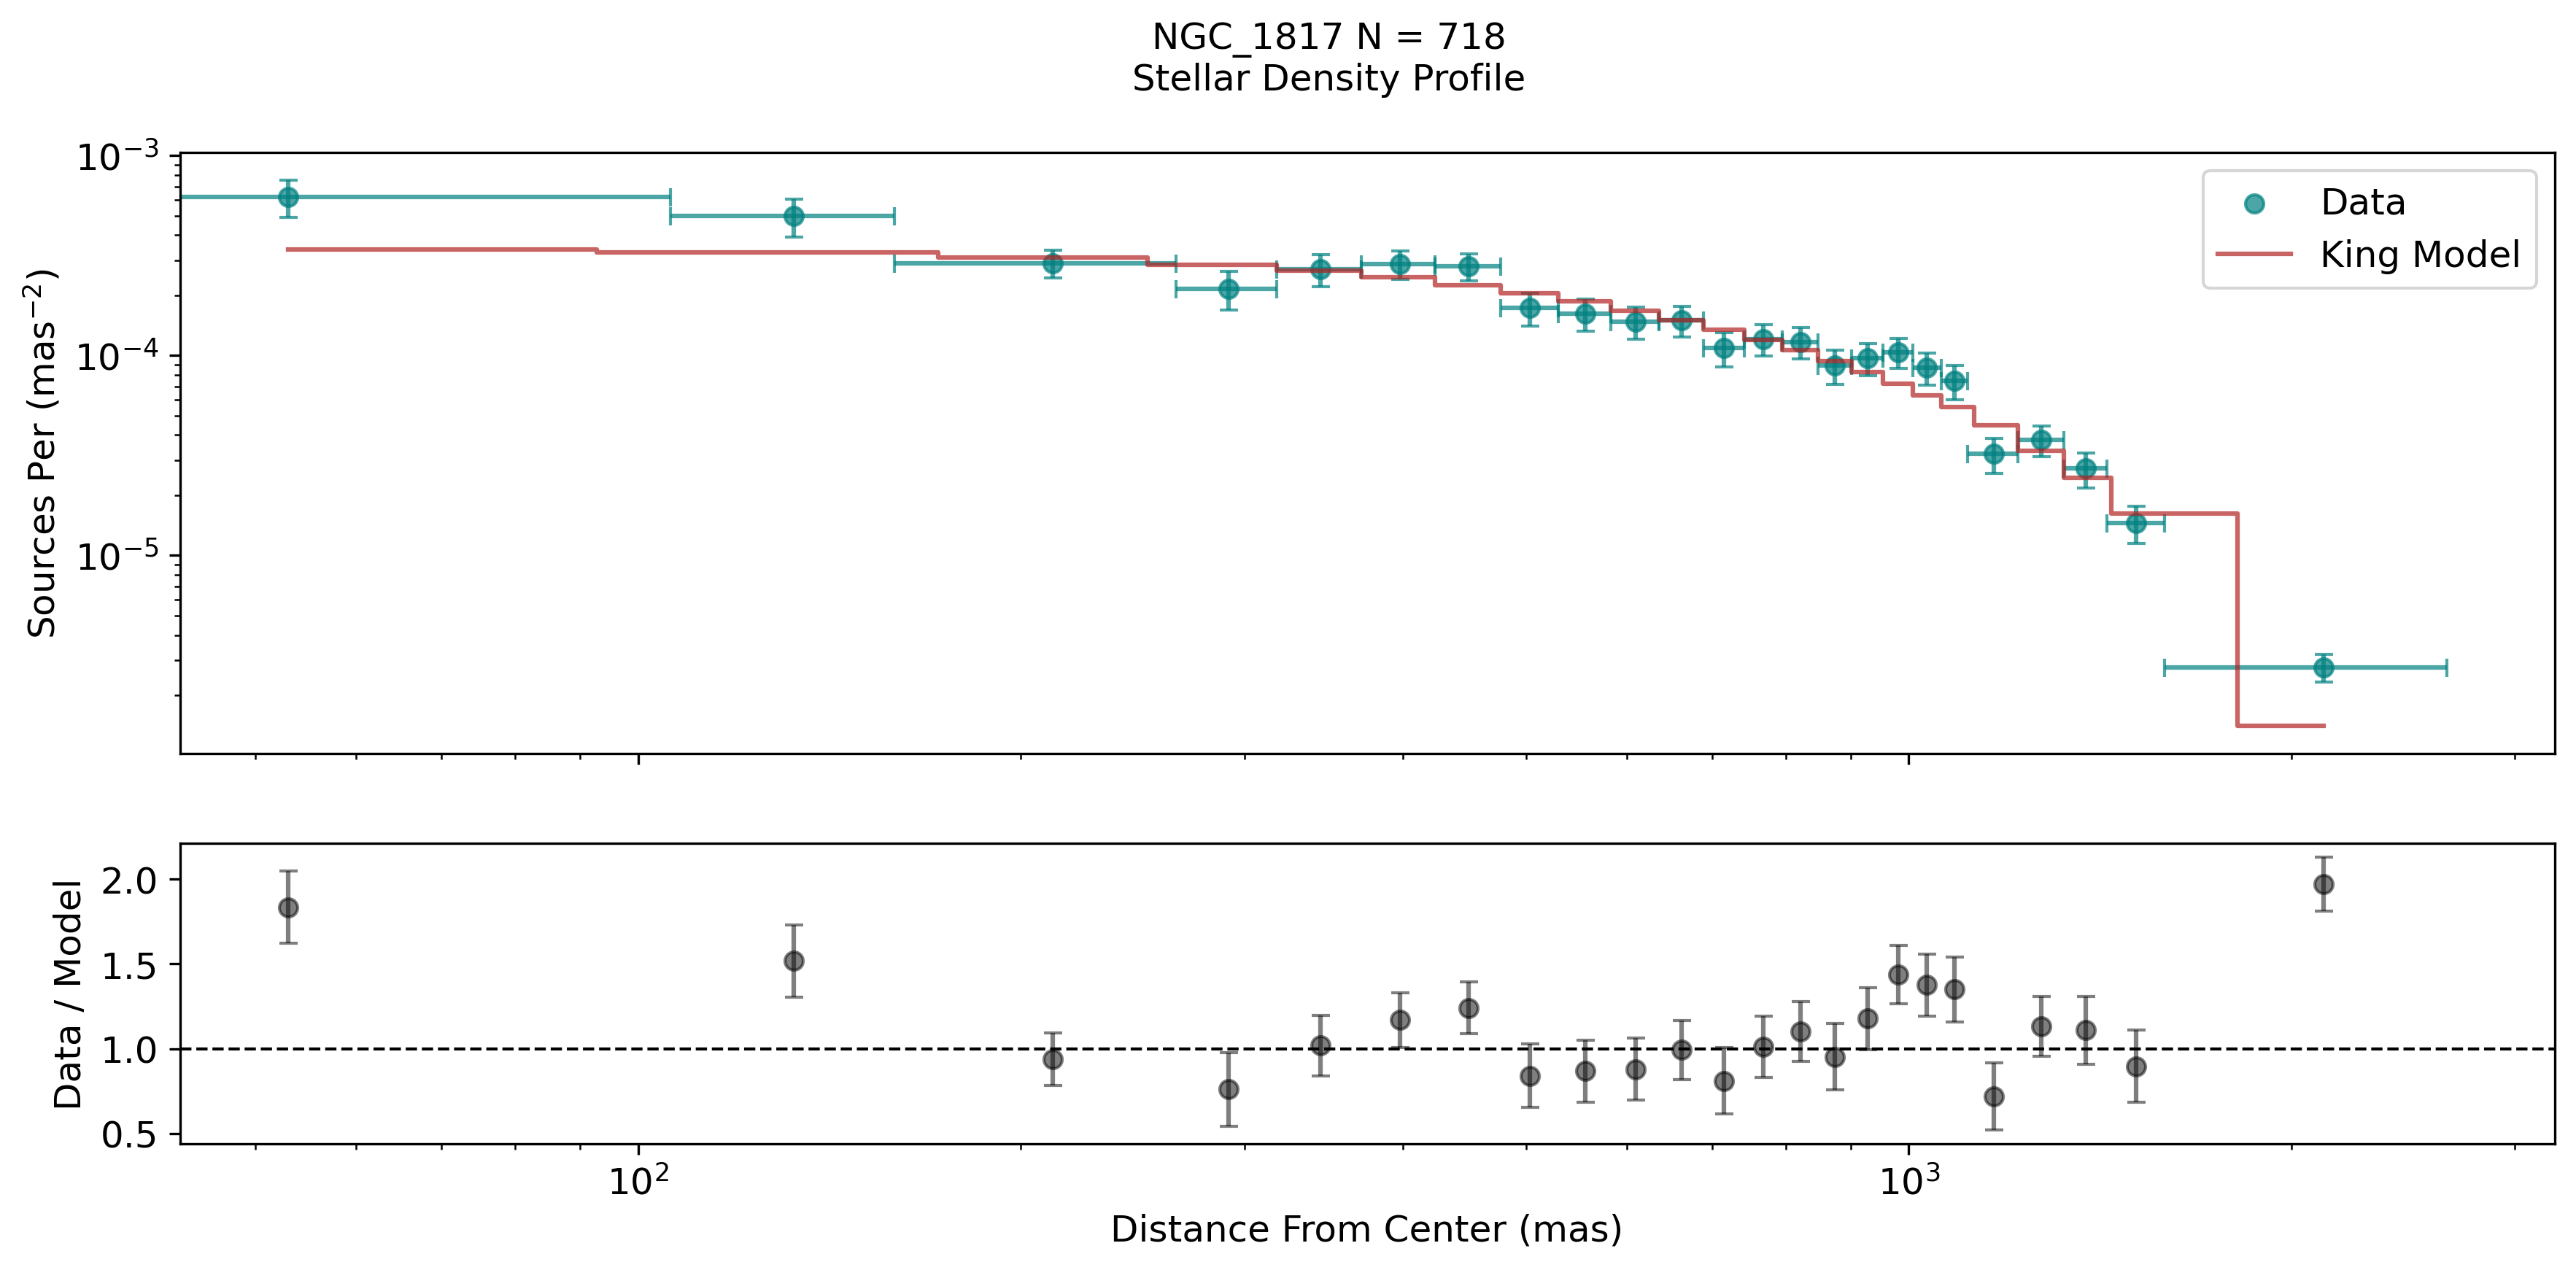

Parameter ranges for grid: [[0, 0.0018475010051464495], [0, 1.1492916651131428e-05], [0, 1793.6457700444025], [4.356822934860702, 4624.70711001032]]


MLE with 1 Sigma Erros
MLE rho_knot: 0.0007966357548647037 with 1 Sigma errors: [-0.00012484  0.00021447]
MLE c: 2.5848730219534884e-06 with 1 Sigma errors: [-2.46626733e-06  5.87865483e-07]
MLE r_c: 830.7753330492689 with 1 Sigma errors: [-149.17781326  177.05139544]
MLE r_t: 2220.9908536750418 with 1 Sigma errors: [-211.68642392  492.97013965]


MLE with 3 Sigma Erros
MLE rho_knot: 0.0007966357548647037 with 3 Sigma errors: [-0.00012534  0.00103322]
MLE c: 2.5848730219534884e-06 with 3 Sigma errors: [           nan 1.49169037e-06]
MLE r_c: 830.7753330492689 with 3 Sigma errors: [-398.53450504  790.69207592]
MLE r_t: 2220.9908536750418 with 3 Sigma errors: [-466.4182768          nan]


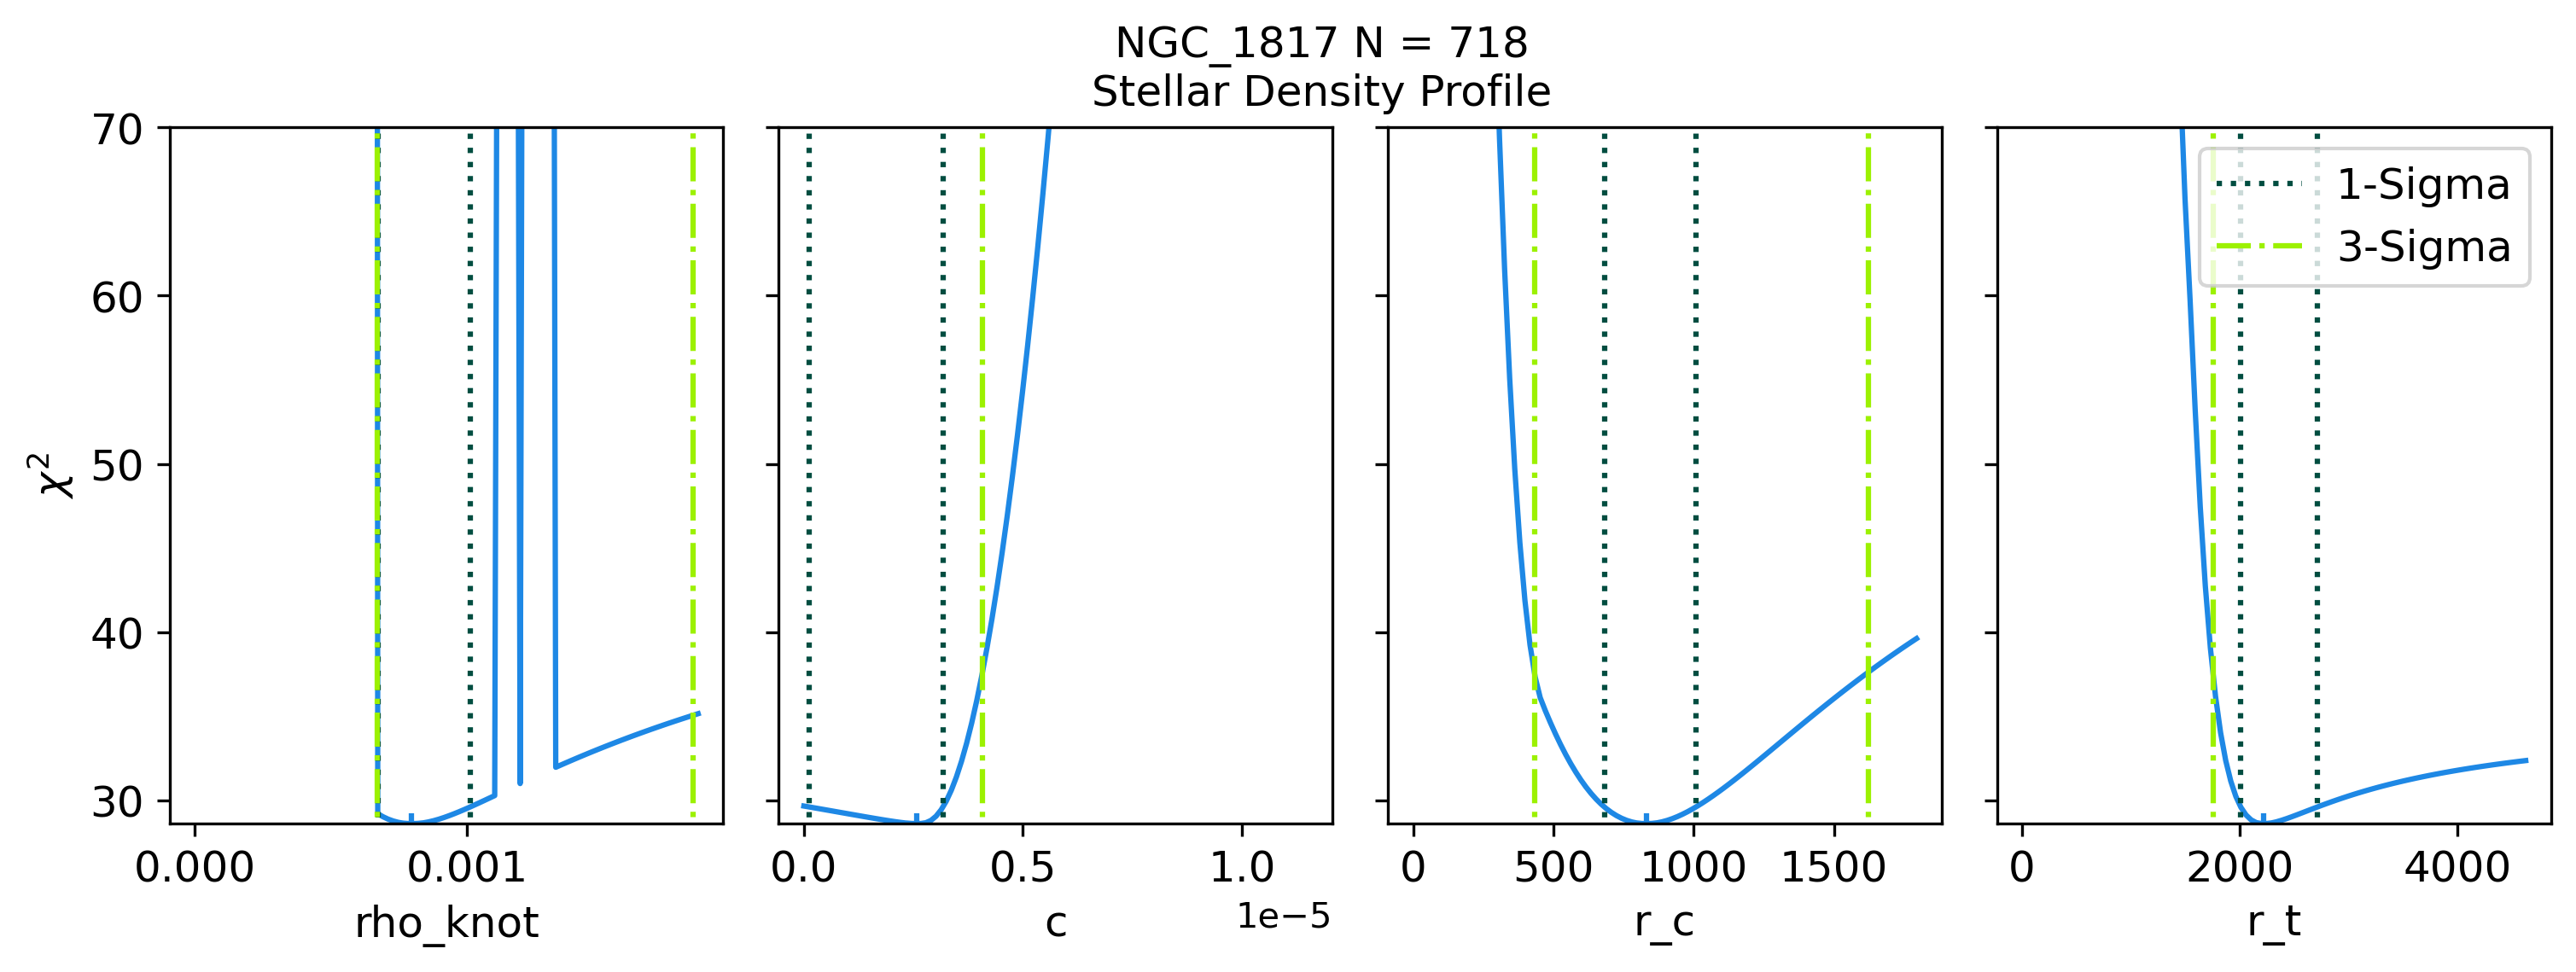

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 66
    # data points      = 23
    # variables        = 4
    chi-square         = 44.2400321
    reduced chi-square = 2.32842274
    Akaike info crit   = 23.0451249
    Bayesian info crit = 27.5871018
[[Variables]]
    rho_knot:  0.00124906 +/- 1.5727e-04 (12.59%) (init = 1)
    c:         2.5472e-07 +/- 3.5964e-07 (141.19%) (init = 1e-05)
    r_c:       306.176380 +/- 34.6672322 (11.32%) (init = 500)
    r_t:       4816.41448 +/- 794.099482 (16.49%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, r_t)        = -0.8833
    C(rho_knot, r_c) = -0.7954
    C(r_c, r_t)      = -0.6621
    C(c, r_c)        = +0.5212
    C(rho_knot, r_t) = +0.1784
    C(rho_knot, c)   = -0.1140
Minimum Chi-squared = 44.24003210473128 for 19 d.o.f.
The goodness of fit is:  0.0008747366716560398


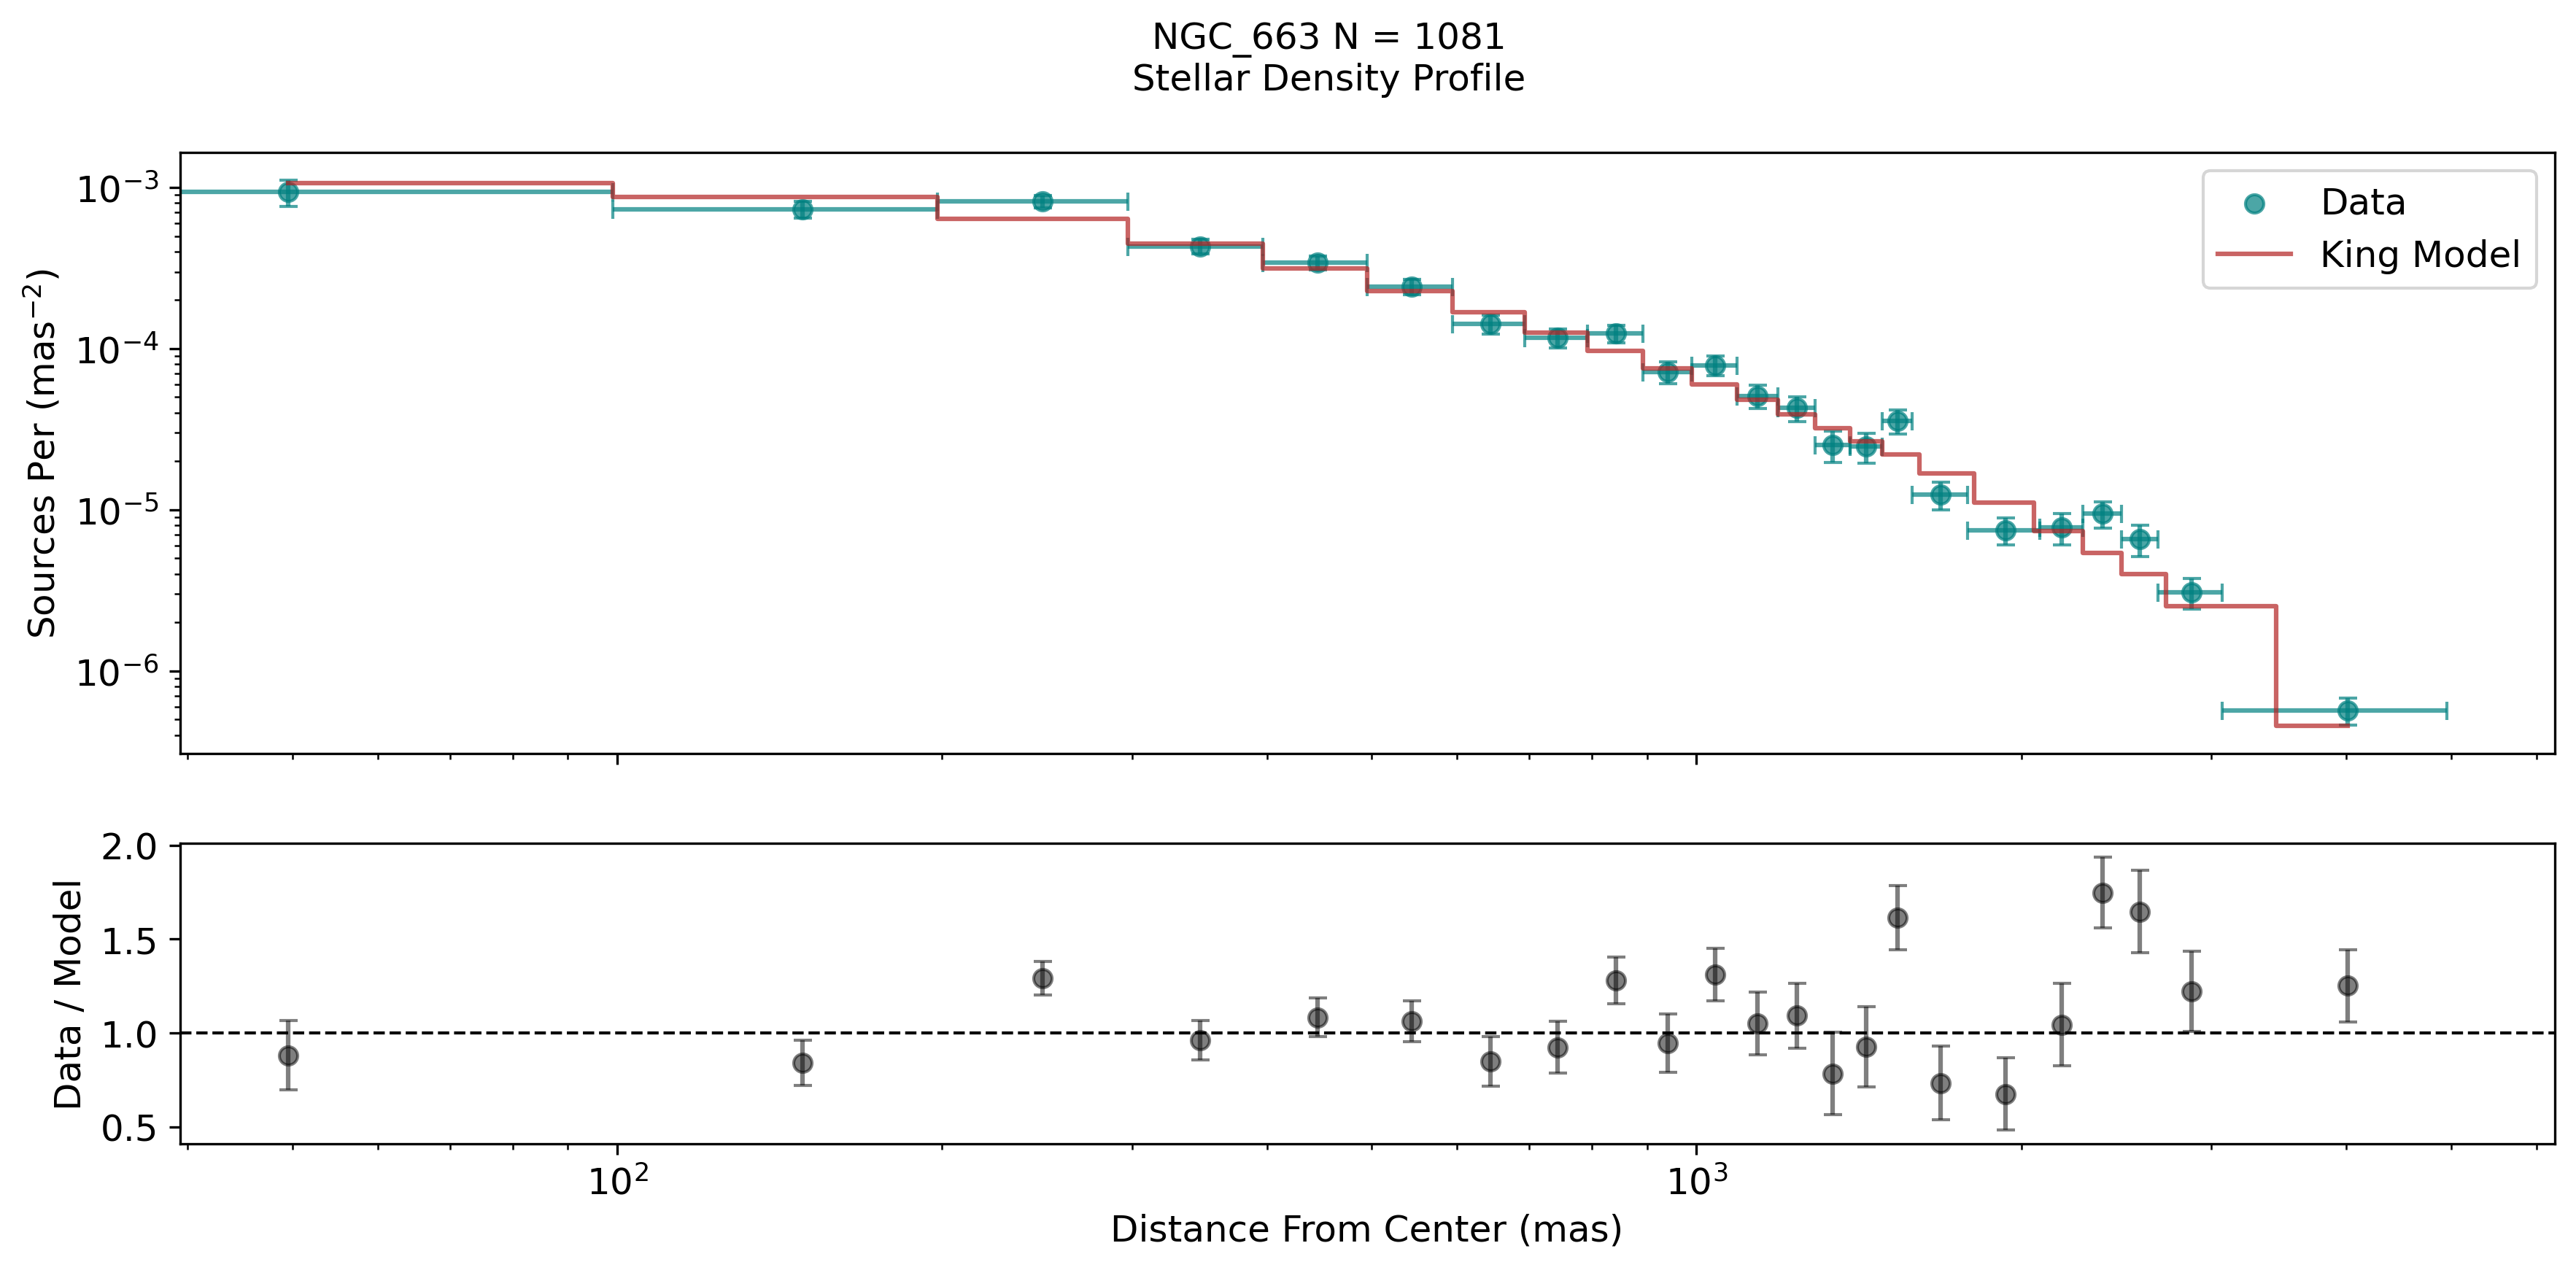

Parameter ranges for grid: [[0.00030542110207912765, 0.002192690374272689], [0, 2.4125535086132657e-06], [98.17298691310822, 514.1797727914673], [51.817588544370665, 9581.011368107433]]


MLE with 1 Sigma Erros
MLE rho_knot: 0.0012254987057277167 with 1 Sigma errors: [-9.10715086e-05  9.63663378e-05]
MLE c: 4.361881444575129e-07 with 1 Sigma errors: [-2.61784672e-07  1.84014258e-07]
MLE r_c: 312.1959660248467 with 1 Sigma errors: [-20.42191501  21.84206915]
MLE r_t: 4691.029039899094 with 1 Sigma errors: [-401.85576557  561.09869355]


MLE with 3 Sigma Erros
MLE rho_knot: 0.0012254987057277167 with 3 Sigma errors: [-0.00026015  0.00030658]
MLE c: 4.361881444575129e-07 with 3 Sigma errors: [           nan 4.54895102e-07]
MLE r_c: 312.1959660248467 with 3 Sigma errors: [-57.73881812  70.76990305]
MLE r_t: 4691.029039899094 with 3 Sigma errors: [-962.52478959 2772.5147315 ]


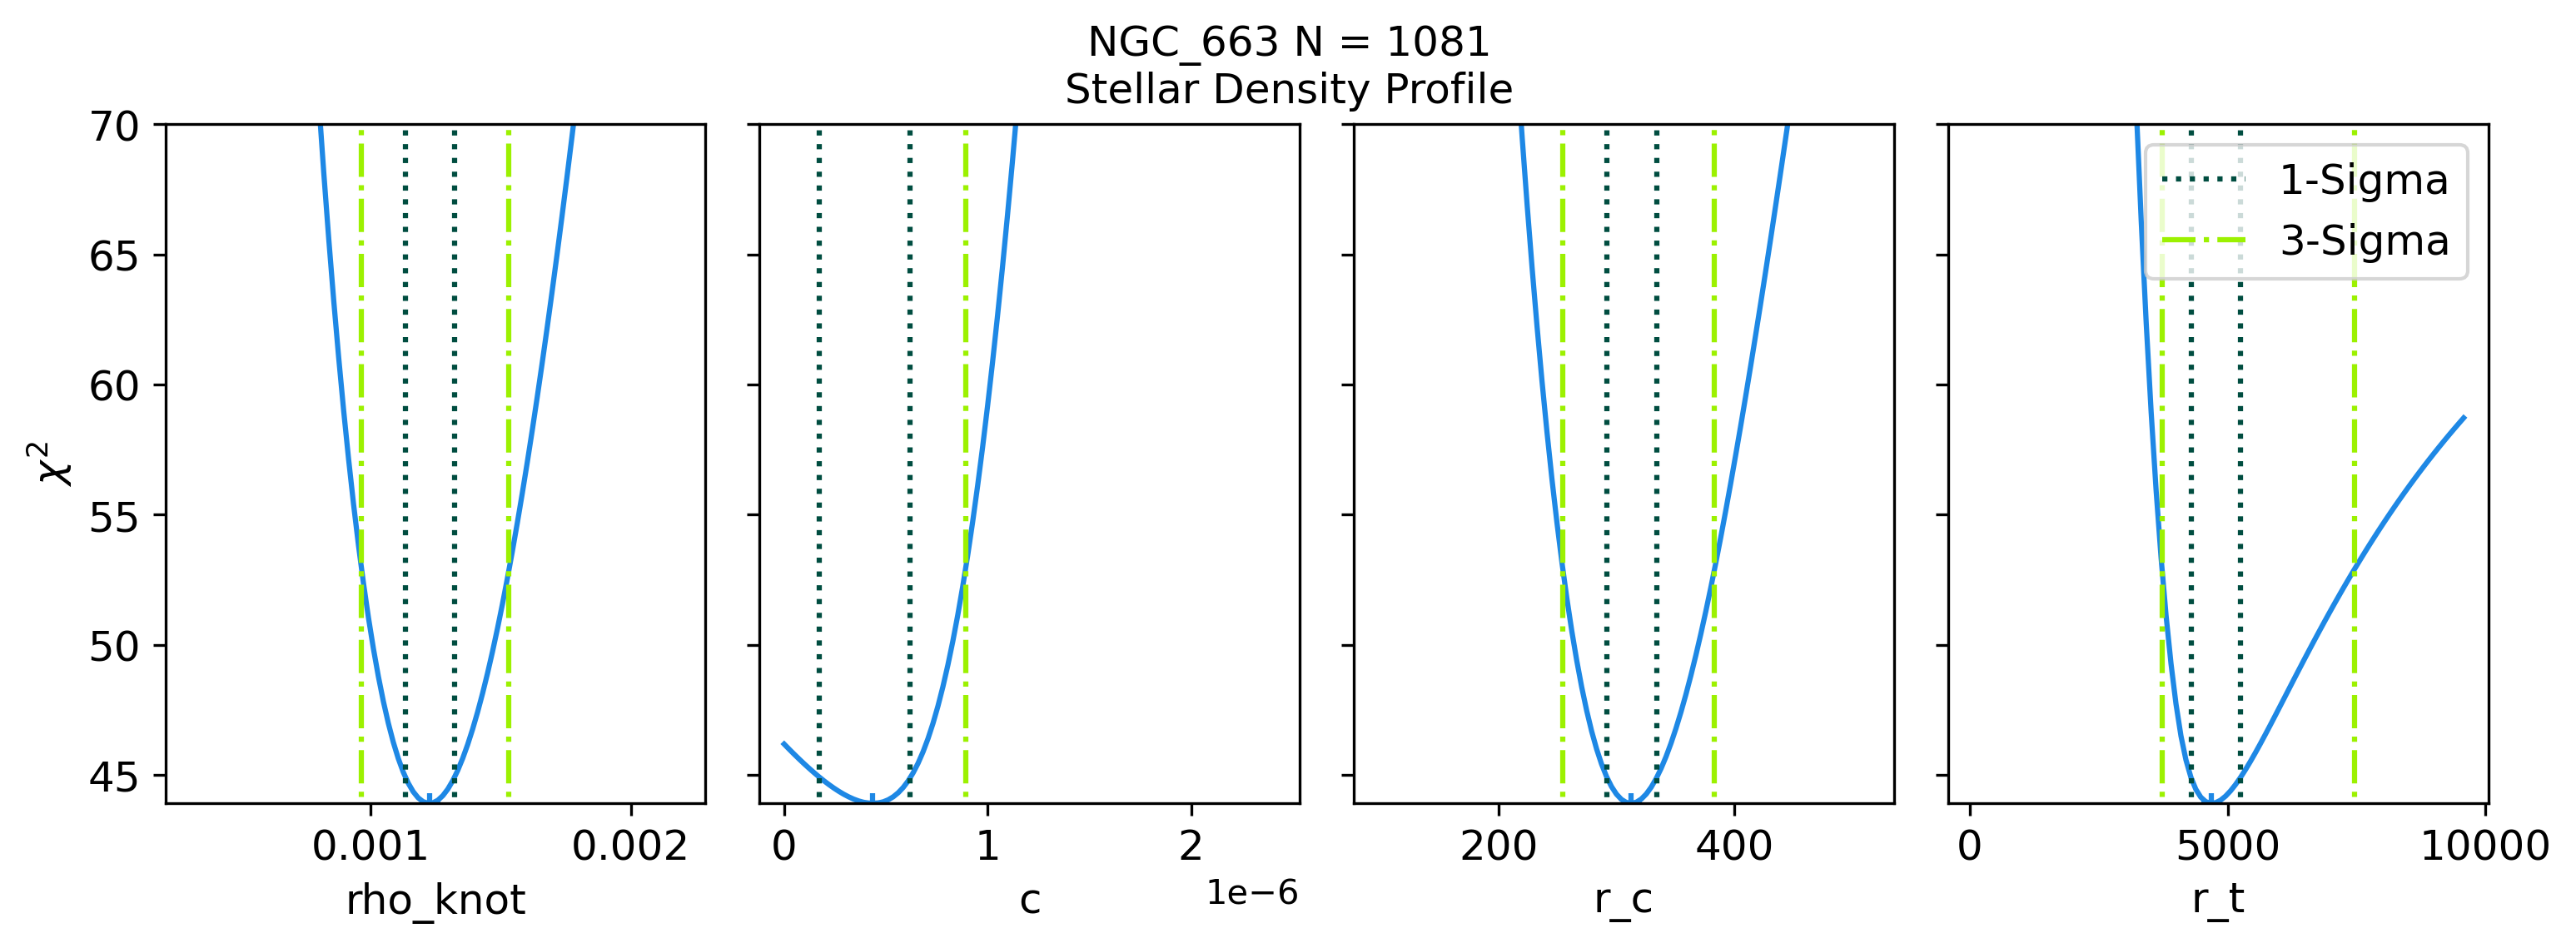

In [11]:
# aprox 2 min for three clusters, most of this is in the confidence intervals function 
cluster_results = []
for cluster_name in assigned_clusters:
    result, xdata,ydata,yerrs  = fit_and_plot_king(stars_df, cluster_name, print_output=True, plot=True)
    get_confidence_intervals(result, stars_df, cluster_name, plotting=True, print_output=True)
    cluster_results.append(result)

## Task 2: Comments

Overview:
* Fitted models seem reasonably ok
    - Goodness of fits were 0.003,0.09,0.0008, a 3 sigma corresponds to a p value of ~0.001. while a 5 sigma is ~ 1e-7. For 2 fits, the model seems to suck (IE be worse then 3 sigma, but better then 5), and one fit appers to be good with a p value of less then 3 sigma. 
* the errors on the MLE parameter values for $r_c$ and $r_t$ are aproximately normal for 1-sgima, and not as much for 3 sigma. 
    - if the errors were normal, we would expect the $\chi^2$ distrubution to look like parabola, and be symetrical. For 1 sigma this holds for 2 clusters quite well and poorly for 1. 
    - for 3, sigma the MLEs start to look not parbolic, and not symetric indicating that the errors are not normally distrubuted for 3 sigma. 
    - for $r_t$, the results indicate that the model is sensitive for a lower bound on the value, while higher values have less impact on the model - and hence a larger spread on that half of the MLE. 
    - $r_c$ follows a similar trend but is far closely to being normally distrubuted 
    - one cluster looks fucked up in terms of its $\chi^2$ distrubution, not sure why or how. 

* Calculating error regions via brute force method takes a lot of computer time! ~30 sec per cluster even only using n=100! Earlier I had n=1000 and it was around 2.5 min per cluster



Conclusion:
- Our clusters are not nicely behaved 
- $r_c$, $r_t$, are more sensitive at lower limits then upper limits on fitted values 
- perhaps the the model would do better if we set the constant to 0 (exercise left to the marker)
- Brute force methods for error regions are expensive to computationaly calculate

# Task 3
An interesting question is whether or not the stars in a cluster follow the same stellar density profiles
when they are selected according to different properties. In particular, we would like to see if the
populations are well mixed according to their G band magnitude and their absolute proper motion
(combining RA and DE proper motion directions). If they are well-mixed, subsamples selected on the
given quantity will show similar density profiles. For each of these two quantities, split the stars from
each cluster into two subsamples corresponding to different percentile ranges (your choice) of the
given observable quantity. Then for each cluster, fit the resulting two density profiles together and
determine whether the stellar density profile model parameters depend on the chosen quantity. 

## Ideas:

* First before we decide on any percentile business we want to visually inspect the data! We must always do so!
    - I will make plots of histograms and and a scatter gram, and a box plot. We are looking for any obious data trends between the two variables
    - note to marker (I should have included distance from center but Its too late, this was extra anyway)

* Decide on percentiles based on observed data trends, if not we will go with upper and lower regions from the box plot
* follow closely the tutorial code for fitting multiple data sets. 
    - this involves making a new king model function that can take in multiple data sets
    - assigning all all params to be at first fixed, and then freeing 1, by 1 by 1, 

## Assumptions
* Same as above for other parts of the code
* we will use the same initial guess and param bounds as before

## order of freeing Params:
* all fixed, 
* rho_knot freed
* rho_knot + r_c freed
* rho_knot + r_c + r_t freed

Let us use the same 3, 5 sigma cut off for model comparisons with fixed and not fixed. This allows us to do more comments

Null Hypothesis:

null-hypothesis our data sets are independent of rho_knot, rc, rt





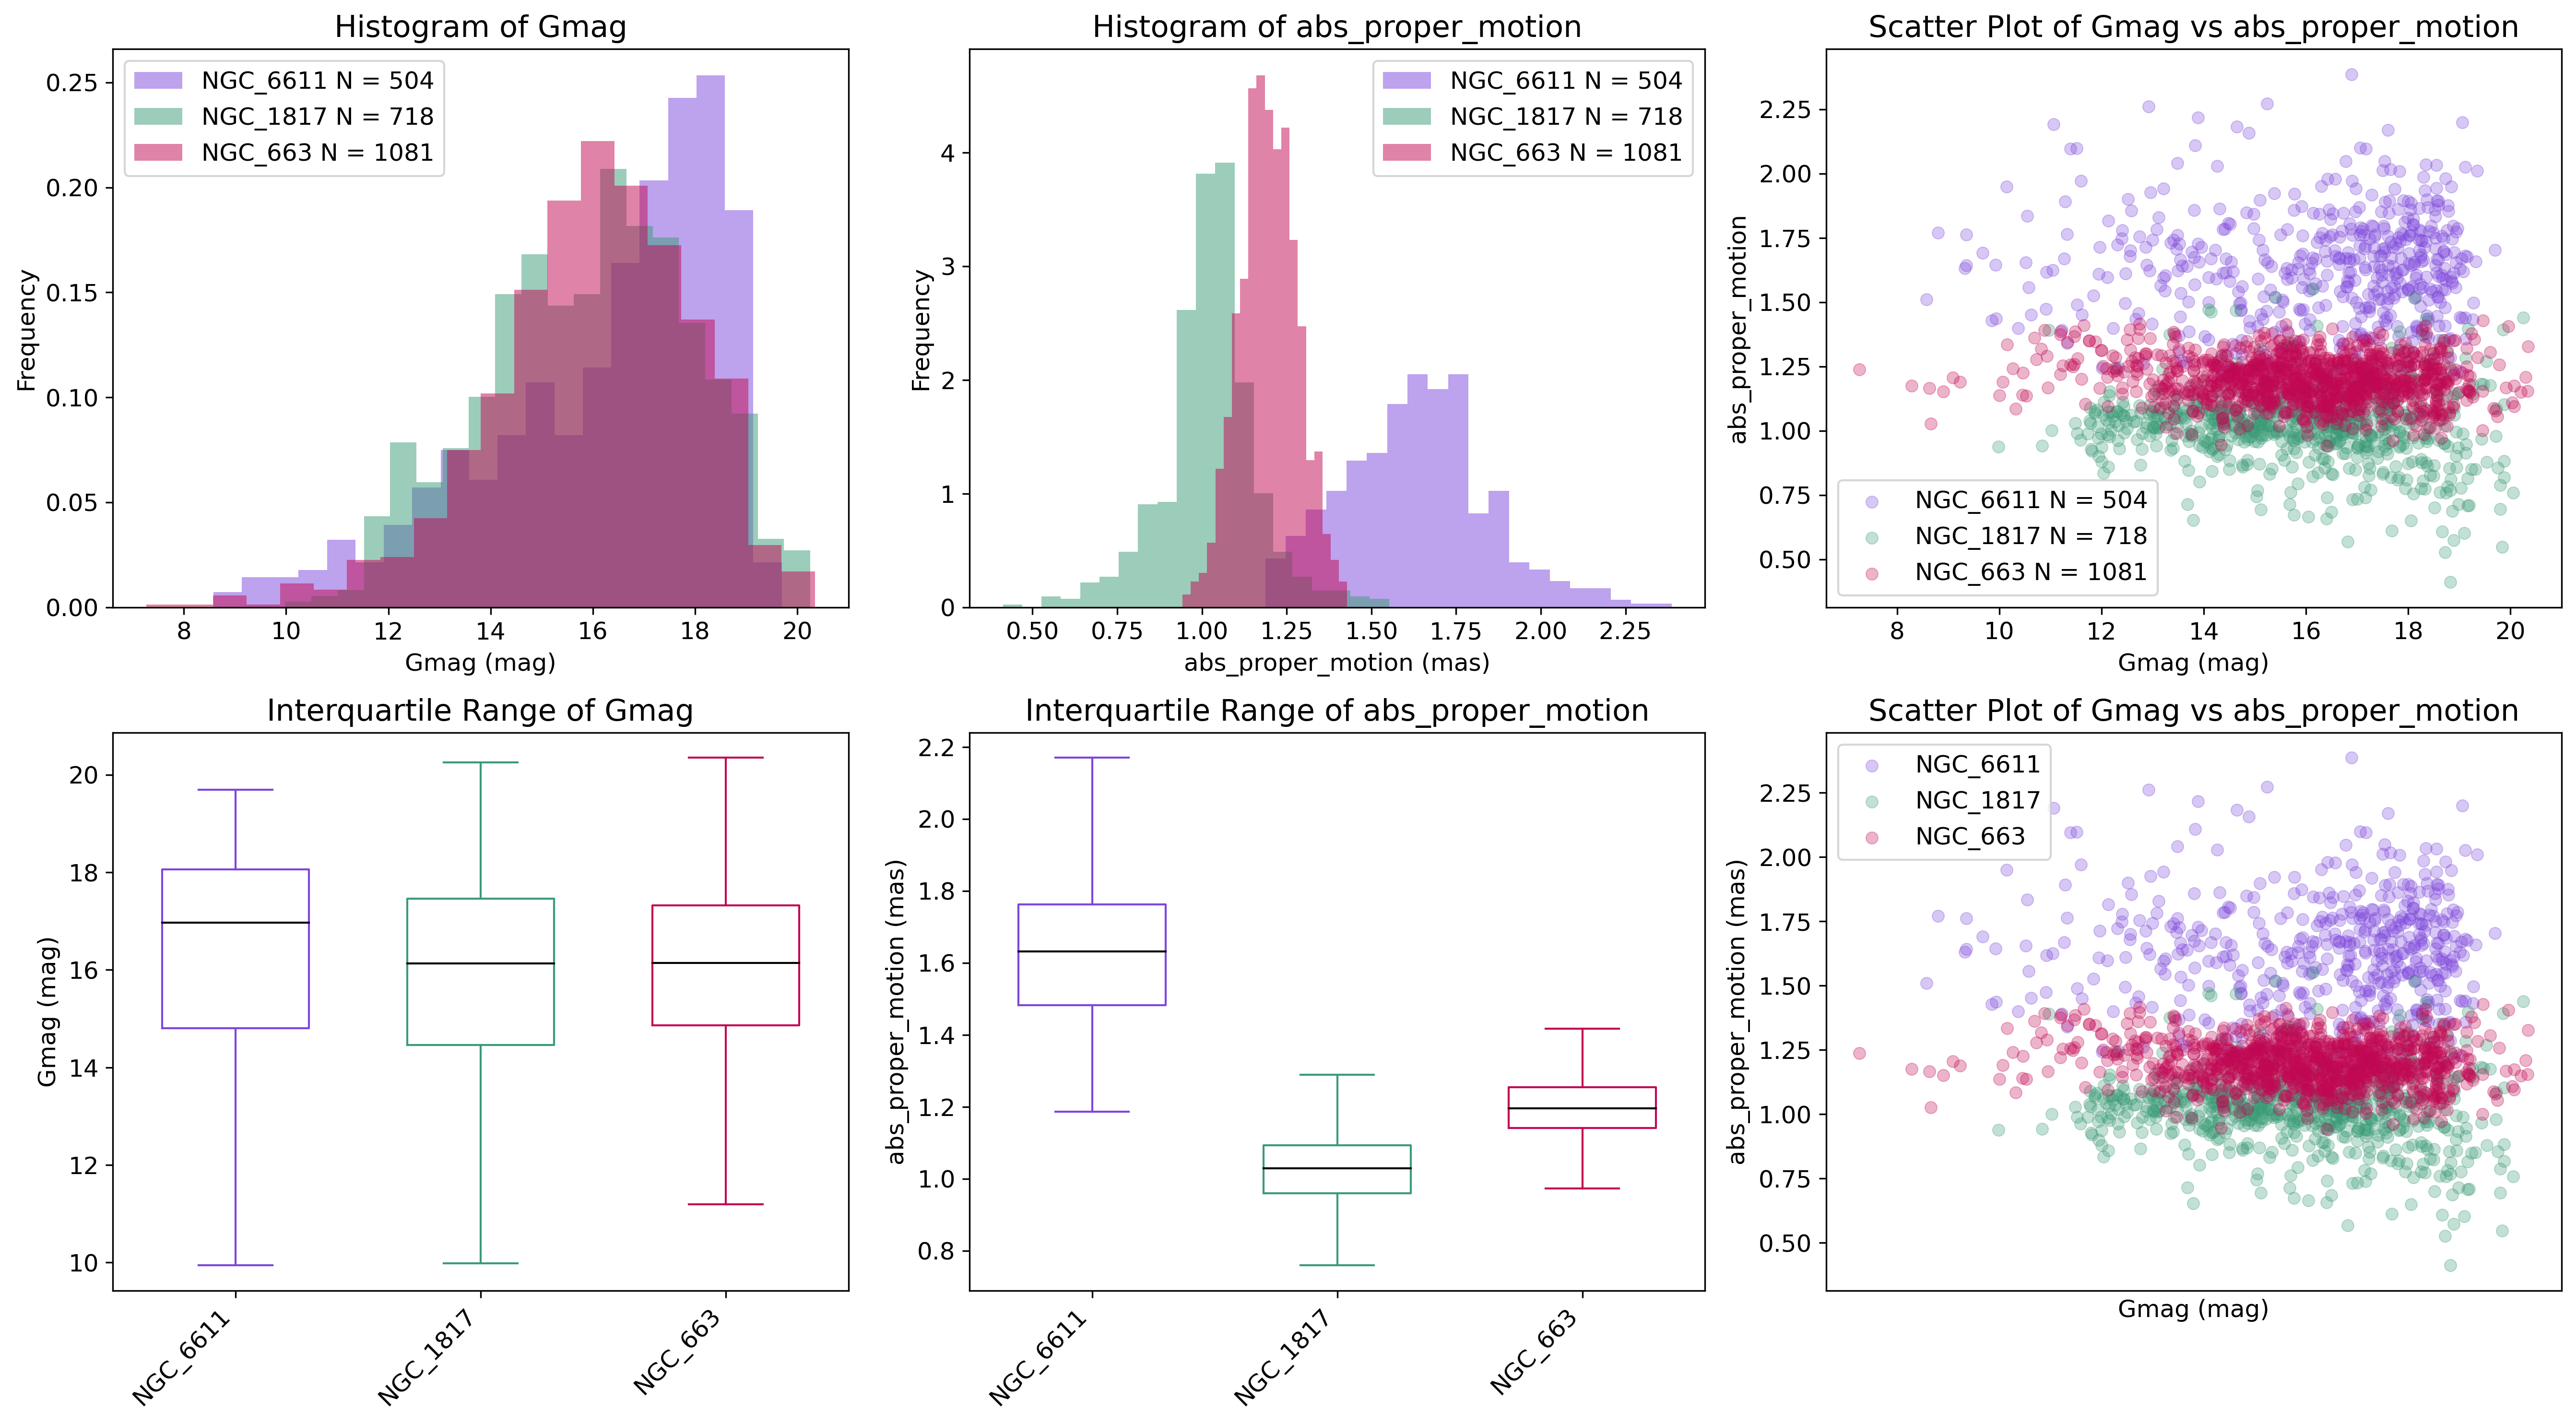

In [12]:
# Create subplots with two side-by-side histograms and one scatter plot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), dpi=300)

# custom colors
colors = ['#7D46DC', '#3A9B76', '#C20853']

# Iterate over each star name and plot histograms
for i, cluster_name in enumerate(assigned_clusters):
    cluster_data = stars_df[stars_df['Name'] == cluster_name]

    label = cluster_name + ' N = ' + str(len(cluster_data['Gmag']))

    # Histogram for 'Gmag'
    axs[0, 0].hist(cluster_data['Gmag'], bins=20, alpha=0.5, color=colors[i], label=label, density=True)

    # Histogram for 'abs_proper_motion'
    axs[0, 1].hist(cluster_data['abs_proper_motion'], bins=20, alpha=0.5, color=colors[i], label=label, density=True)

    # Scatter plot for 'Gmag' vs 'abs_proper_motion'
    axs[0, 2].scatter(cluster_data['Gmag'], cluster_data['abs_proper_motion'], color=colors[i], label=label, alpha=0.3, linewidth=0.5)
    axs[0, i].tick_params(axis='both', which='both', labelsize=12)
    #axs[i, i].tick_params(axis='both', which='both', labelsize=12)
    axs[0, i].tick_params(axis='both', which='both', labelsize=12)
    axs[1, i].tick_params(axis='both', which='both', labelsize=12)
   # axs[2, i].tick_params(axis='both', which='both', labelsize=12)

# Set labels and titles for histograms
axs[0, 0].set_xlabel('Gmag (mag)', size=12)
axs[0, 0].set_ylabel('Frequency', size=12)
axs[0, 0].set_title('Histogram of Gmag', size=15)

axs[0, 1].set_xlabel('abs_proper_motion (mas)', size=12)
axs[0, 1].set_ylabel('Frequency', size=12)
axs[0, 1].set_title('Histogram of abs_proper_motion', size=15)

# Set labels and title for scatter plot
axs[0, 2].set_xlabel('Gmag (mag)', size=12)
axs[0, 2].set_ylabel('abs_proper_motion', size=12)
axs[0, 2].set_title('Scatter Plot of Gmag vs abs_proper_motion', size=15)

# Add legend to all subplots
axs[0, 0].legend(fontsize=12)
axs[0, 1].legend(fontsize=12)
axs[0, 2].legend(fontsize=12)

# Iterate over each star name and plot interquartile range diagrams
for i, cluster_name in enumerate(assigned_clusters):
    cluster_data = stars_df[stars_df['Name'] == cluster_name]

    # Interquartile range diagram for 'Gmag'
    axs[1, 0].boxplot(cluster_data['Gmag'], positions=[i], widths=0.6, showfliers=False, boxprops=dict(color=colors[i]),
                   medianprops=dict(color='black'), whiskerprops=dict(color=colors[i]), capprops=dict(color=colors[i]))

    # Interquartile range diagram for 'abs_proper_motion'
    axs[1, 1].boxplot(cluster_data['abs_proper_motion'], positions=[i], widths=0.6, showfliers=False,
                   boxprops=dict(color=colors[i]), medianprops=dict(color='black'),
                   whiskerprops=dict(color=colors[i]), capprops=dict(color=colors[i]))

    # Scatter plot for 'Gmag' vs 'abs_proper_motion'
    axs[1, 2].scatter(cluster_data['Gmag'], cluster_data['abs_proper_motion'], color=colors[i], label=cluster_name, alpha=0.3, linewidth=0.5)
    

# Set labels and titles for interquartile range diagrams
#axs[1, 0].set_xlabel('Cluster', size=12)
axs[1, 0].set_ylabel('Gmag (mag)', size=12)
axs[1, 0].set_title('Interquartile Range of Gmag', size=15)

#axs[1, 1].set_xlabel('Cluster', size=12)
axs[1, 1].set_ylabel('abs_proper_motion (mas)', size=12)
axs[1, 1].set_title('Interquartile Range of abs_proper_motion', size=15)

# Set labels and title for scatter plot
axs[1, 2].set_xlabel('Gmag (mag)', size=12)
axs[1, 2].set_ylabel('abs_proper_motion (mas)', size=12)
axs[1, 2].set_title('Scatter Plot of Gmag vs abs_proper_motion', size=15)

# Set x-axis ticks to cluster names
axs[1, 0].set_xticks(range(len(assigned_clusters)))
axs[1, 0].set_xticklabels(assigned_clusters, rotation=45, ha='right')

axs[1, 1].set_xticks(range(len(assigned_clusters)))
axs[1, 1].set_xticklabels(assigned_clusters, rotation=45, ha='right')

axs[1, 2].set_xticks([])  # No x-axis ticks for the scatter plot

# Add legend to the scatter plot
axs[1, 2].legend(fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig('merged_plots', bbox_inches='tight')
plt.show()


# Comment on data trends

* no clear data trends, between Gmag, and proper motion 

* I will be picking percentiles for data, on the lowest 25%, and highest 75% (box plot!), I will also use a third data set consiting of all the data for a given cluster

In [13]:
# pick percentiles for data, 

percentile_low = 25
percentile_high = 75

# Function to compute percentiles within each cluster
def compute_percentiles(group):
    """
    Compute percentiles within each cluster for 'Gmag' and 'abs_proper_motion'.

    Parameters:
    - group (DataFrame): A pandas DataFrame representing a cluster of stars.
    - percentile_low (float, optional): The lower percentile value (default is 25).

    Returns:
    - DataFrame: The input DataFrame with two additional columns indicating the percentiles
      of 'Gmag' and 'abs_proper_motion' within the specified cluster.
      Columns added: 'Gmag_percentile_range' and 'abs_proper_motion_percentile_range'.
      The percentiles are categorized into two ranges: 'low_percentile' and 'high_percentile'.
    """
    group['Gmag_percentile_range'] = pd.cut(group['Gmag'],
                                             bins=[-float('inf'), group['Gmag'].quantile(percentile_low/100), float('inf')],
                                             labels=['Gmag_low_percentile', 'Gmag_high_percentile'])
    
    group['abs_proper_motion_percentile_range'] = pd.cut(group['abs_proper_motion'],
                                                         bins=[-float('inf'), group['abs_proper_motion'].quantile(percentile_low/100), float('inf')],
                                                         labels=['abs_proper_motion_low_percentile', 'abs_proper_motion_high_percentile'])
    return group

# Apply the function within each cluster
stars_df = stars_df.groupby('Name').apply(compute_percentiles)

# Optional: Remove the temporary columns if needed
# stars_df = stars_df.drop(columns=['Gmag_percentile_range', 'abs_proper_motion_percentile_range'])

# Split the data into two DataFrames based on the percentile_range columns
low_percentile_data = stars_df[stars_df['Gmag_percentile_range'] == 'Gmag_low_percentile']
high_percentile_data = stars_df[stars_df['Gmag_percentile_range'] == 'Gmag_high_percentile']

cluster_stars = stars_df[stars_df['Name'] == cluster_name]
selected_percentile = cluster_stars[cluster_stars['Gmag_percentile_range'] == 'Gmag_low_percentile']['Gmag_percentile_range']

# Now we do the code only for Gmag, and we will repeat the same code for proper motion. 
- this would be better as a function, but since we are only doing it twice I think it is acceptable

In [14]:
####################### my version
###################### Only for gmag


nbins = 50
# And now we use our new function to rebin so there are at least mincounts counts per bin:
mincounts = 20  # Here we set it to our minimum requirement of 20, but in principle you could set it higher

xdata = []  # We create empty lists to assign our binned spectra to lists for lmfit to fit them together
ydata = []
yerrs = []

for cluster_name in assigned_clusters[0:1]:
    #  First read in the data.  This is a simple (single-column) list of energies:

    # low range  gmag
    cluster_stars = stars_df[stars_df['Name'] == cluster_name]
    selected_percentile = cluster_stars[cluster_stars['Gmag_percentile_range'] == 'Gmag_low_percentile']['radial_separation_arcsec']


    counts, edges = np.histogram(selected_percentile, bins=nbins, density=False)
    counts2, edges2 = histrebin(mincounts,counts,edges)

    bins = edges2
    hist = counts2
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers = bin_centers
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  # this is wrong?
    #annulus_area = np.pi * np.diff(bins)**2
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area

    # not the count density, so we have to also apply the same normalisation.
    xdata.append(bins) # Now assign to our lists for lmfit
    ydata.append(stellar_density)
    yerrs.append(std_stellar_den) 

    print(' ')
    print('len xdata i ', len(bins))
    print('len ydata i ', len(stellar_density))
    print('len ydata err i ', len(std_stellar_den))

    # high range  gmag
    cluster_stars = stars_df[stars_df['Name'] == cluster_name]
    selected_percentile = cluster_stars[cluster_stars['Gmag_percentile_range'] == 'Gmag_high_percentile']['radial_separation_arcsec']


    counts, edges = np.histogram(selected_percentile, bins=nbins, density=False)
    counts2, edges2 = histrebin(mincounts,counts,edges)

    bins = edges2
    hist = counts2
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers = bin_centers
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  # this is wrong?
    #annulus_area = np.pi * np.diff(bins)**2
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area

    # not the count density, so we have to also apply the same normalisation.
    xdata.append(bins) # Now assign to our lists for lmfit
    ydata.append(stellar_density)
    yerrs.append(std_stellar_den) 

    print(' ')
    print('len xdata i ', len(bins))
    print('len ydata i ', len(stellar_density))
    print('len ydata err i ', len(std_stellar_den))


    # all data 
    cluster_stars = stars_df[stars_df['Name'] == cluster_name]
    selected_percentile = cluster_stars['radial_separation_arcsec']

    counts, edges = np.histogram(selected_percentile, bins=nbins, density=False)
    counts2, edges2 = histrebin(mincounts,counts,edges)

    bins = edges2
    hist = counts2
    bin_centers = (bins[:-1] + bins[1:]) / 2
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  # this is wrong?
    #annulus_area = np.pi * np.diff(bins)**2
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area

    # not the count density, so we have to also apply the same normalisation.
    xdata.append(bins) # Now assign to our lists for lmfit
    ydata.append(stellar_density)
    yerrs.append(std_stellar_den) 

    print(' ')
    print('len xdata i ', len(bins))
    print('len ydata i ', len(stellar_density))
    print('len ydata err i ', len(std_stellar_den))








    

 
len xdata i  6
len ydata i  5
len ydata err i  5
 
len xdata i  14
len ydata i  13
len ydata err i  13
 
len xdata i  14
len ydata i  13
len ydata err i  13


In [15]:
# updated for multi data fits 

def model_bin_mult(xbins, model, i_data, params):
    '''General function for integrating the input model over bins defined by contiguous (no gaps) 
        bin edges, xbins.
       Inputs:
           xbins - x bin edges.
           i_data - the dataset being considered (determines which parameters to use in the model)
           model, params - the model name and associated Parameters object.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(xbins)-1)
    for i, xval in enumerate(xbins[:-1]):
        ymod[i], ymoderr = spint.quad(lambda x: model(x, i_data, params),xbins[i],xbins[i+1])
        ymod[i] = ymod[i]/(xbins[i+1]-xbins[i])  # we now divide by the bin width to match the counts density
        # units of our data
    return ymod

def lmf_lsq_binresid_mult(params,xdata,ydata,yerrs,model,output_resid=True):
    '''lmfit objective function to calculate and return residual array or model y-values for
        binned data where the xdata are the input bin edges and ydata are the densities (integral over bin
        divided by bin width).
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
        Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)'''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
                     # Note that we identify the dataset by counting from 1 not 0, this is just the 
                    # standard we will use for naming the parameters.
            if i == 0:
                resid = (ydata[i]-model_bin_mult(xdata[i],model,i+1,params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model_bin_mult(xdata[i],model,i+1,params))/yerrs[i])
        return resid
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin_mult(xdata[i],model,i+1,params))
        return ymodel

In [16]:
#### updated king model 
def pl_model_mult(x, i_data, params):
    '''Simple power-law function to fit multiple datasets.
       Inputs:
           x - input x value(s) (can be list or single value).
           i_data - Index of dataset
           params - lmfit Parameters object: PL normalisation (at x = 1) and power-law index.'''
    v = params.valuesdict()
    return v['N_'+str(i_data)] * x**v['gamma_'+str(i_data)]



def king_model_multi(x, i_data, params):
    r = x
    
    param_values = {}
    for param_name in params.keys():
        param_values[param_name] = params[param_name].value if isinstance(params[param_name], lmfit.Parameter) else params[param_name]

    # Now, you can access individual parameter values using param_values dictionary
    rho_knot = param_values['rho_knot_' + str(i_data)]
    c = param_values['c_' + str(i_data)]
    r_c = param_values['r_c_' + str(i_data)]
    r_t = param_values['r_t_'+ str(i_data)]
        
    # Check if all parameters are numeric
    if not all(isinstance(param, (int, float)) for param in [rho_knot, c, r_c, r_t]):
        print('error in function')
        raise ValueError("All parameters must be numeric.")
    
    # Perform calculations
    frac1 = 1 / np.sqrt(1 + (r / r_c)**2)
    frac2 = 1 / np.sqrt(1 + (r_t / r_c)**2)
    rho_king = rho_knot * (frac1 - frac2)**2 + c
    
    # Use boolean indexing to set values for r > r_t if rho_king is a NumPy array
    if isinstance(rho_king, np.ndarray):
        rho_king[r > r_t] = c

    else:
        if r > r_t:
            rho_king = c
    
    return rho_king


In [17]:
def plot_spec_model_mult(ebins_list,cdens_list,cdens_err_list,cdens_model_list,emin,emax,resid_type,
                         legend_labels, title='Title'):
    '''Plot the binned (GeV) spectrum with the model as a histogram, and 
       data/model residuals.
       Inputs:
           ebins_list - energy bin edges.
           cdens_list, cdens_err_list - counts density and its error.
           cdens_model_list - model counts density.
           emin, emax - minimum and maximum energy to be plotted
           resid_type - string, type of data vs model residuals, these can be: 
               ratio: data/model, resid: data-model, weighted resid: data-model/error
           legend_labels - list of labels for each dataset to use in legend, 
                   use None if no legend required'''
    
    colors = ['#7D46DC', '#3A9B76', '#C20853']
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,4),sharex=True,gridspec_kw={'height_ratios':[2,1]}, dpi=100)
    fig.subplots_adjust(hspace=0)
    for i,ebins in enumerate(ebins_list):
        energies = (ebins[1:]+ebins[:-1])/2
        bwidths = np.diff(ebins)
        if legend_labels != None:
            label_txt = legend_labels[i]
        # Note that colours in the default Matplotlib colour cycle can be specified using strings 
        # 'C0'..'C9', which is useful for plotting the same colours for model and data.
        ax1.errorbar(energies, cdens_list[i], xerr=bwidths/2., yerr=cdens_err_list[i], 
                     markersize=4, fmt='o', label=label_txt, color=colors[i])
        model_hist, edges, patches = ax1.hist(energies, bins=ebins, weights=cdens_model_list[i], 
                    density=False, histtype='step',  alpha=0.5, 
                                              linestyle='dotted', linewidth=2,color=colors[i])
        if resid_type == 'ratio':
            ax2.errorbar(energies, cdens_list[i]/cdens_model_list[i], xerr=bwidths/2., 
                    yerr=cdens_err_list[i]/cdens_model_list[i], markersize=4, fmt='o', color=colors[i])
        elif resid_type == 'resid':
            ax2.errorbar(energies, (cdens_list[i]-cdens_model_list[i]), xerr=bwidths/2., 
                    yerr=cdens_err_list[i],  markersize=4, fmt='o', color=colors[i])
        elif resid_type == 'weighted resid':
            ax2.errorbar(energies, (cdens_list[i]-cdens_model_list[i])/cdens_err_list[i], xerr=bwidths/2., 
                    yerr=1.0, markersize=4, fmt='o', color=colors[i])
    ax2.set_xlabel('Distance From Center (mas)', size=12)
    ax1.set_ylabel('Sources Per (mas$^{-2}$)', size=12)
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    if resid_type == 'ratio':
        ax2.set_ylabel("data/model", fontsize=14)
        ax2.axhline(1., color='gray', linestyle='dotted', lw=2)
    elif resid_type == 'resid':
        ax2.set_ylabel("data-model", fontsize=14)
        ax2.axhline(0., color='gray', linestyle='dotted', lw=2)
    elif resid_type == 'weighted resid':
        ax2.get_yaxis().set_label_coords(-0.09,0.5)
        ax2.set_ylabel(r"$\frac{data-model}{error}$", fontsize=16)
        ax2.axhline(0., color='gray', linestyle='dotted', lw=2)
    ax1.tick_params(labelsize=14)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax2.tick_params(labelsize=14)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    #ax2.set_xlim(emin,emax) # Strictly speaking we should only show the energy range 
    # where data is sampled, to avoid impression from model that the flux suddenly drops 
    # at the boundaries.
    ax1.legend(fontsize=14)
    plt.suptitle(title + '\n' + cluster_name, size=15)
    plt.show()

In [18]:
# Set params
# all params fixed to first data set
params = Parameters()
params.add_many(('rho_knot_1',1, True, 0, None),('c_1',1e-6,False, 0, None),('r_c_1', 500), ('r_t_1', 1000),
                ############################################################################################
                # second data set
                ('rho_knot_2',1, True, 0, None, 'rho_knot_1'),('c_2',1e-6,False, 0, None, 'c_1'),
                ('r_c_2', 500, True, None, None, 'r_c_1'), ('r_t_2', 1000, True, None, None, 'r_t_1'),
                #############################################################################################
                # third data set
                ('rho_knot_3',1, True, 0, None, 'rho_knot_1'),('c_3',1e-6,False, 0, None, 'c_1'),('r_c_3', 500, True, None, None, 'r_c_1'),
                ('r_t_3', 1000, True, None, None, 'r_t_1'))

# run
model = king_model_multi
output_resid = True
set_function = Minimizer(lmf_lsq_binresid_mult, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_all_fixed = set_function.minimize(method = 'leastsq')
result_null = result_all_fixed
print(' ', ' ', ' ', 'all params fixed')
report_fit(result_null)
print("Minimum Chi-squared = "+str(result_null.chisqr)+" for "+str(result_null.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result_null.chisqr,df=result_null.nfree))


# Set params
# rho knot is free
params = Parameters()
params.add_many(('rho_knot_1',1, True, 0, None),('c_1',1e-6,False, 0, None),('r_c_1', 500), ('r_t_1', 1000),
                ############################################################################################
                # second data set
                ('rho_knot_2',1, True, 0, None, ),('c_2',1e-6,False, 0, None, 'c_1'),
                ('r_c_2', 500, True, None, None, 'r_c_1'), ('r_t_2', 1000, True, None, None, 'r_t_1'),
                #############################################################################################
                # third data set
                ('rho_knot_3',1, True, 0, None, ),('c_3',1e-6,False, 0, None, 'c_1'),('r_c_3', 500, True, None, None, 'r_c_1'),
                ('r_t_3', 1000, True, None, None, 'r_t_1'))

# run
model = king_model_multi
output_resid = True
set_function = Minimizer(lmf_lsq_binresid_mult, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_rho_free = set_function.minimize(method = 'leastsq')
result_null = result_rho_free
print(' ', ' ', ' ', 'rho_knot is freed')
report_fit(result_null)
print("Minimum Chi-squared = "+str(result_null.chisqr)+" for "+str(result_null.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result_null.chisqr,df=result_null.nfree))


# Set params
# r_c is free
params = Parameters()
params.add_many(('rho_knot_1',1, True, 0, None),('c_1',1e-6,False, 0, None),('r_c_1', 500), ('r_t_1', 1000),
                ############################################################################################
                # second data set
                ('rho_knot_2',1, True, 0, None, ),('c_2',1e-6,False, 0, None, 'c_1'),
                ('r_c_2', 500, True, None, None,), ('r_t_2', 1000, True, None, None, 'r_t_1'),
                #############################################################################################
                # third data set
                ('rho_knot_3',1, True, 0, None, ),('c_3',1e-6,False, 0, None, 'c_1'),('r_c_3', 500, True, None, None, ),
                ('r_t_3', 1000, True, None, None, 'r_t_1'))
# run
model = king_model_multi
output_resid = True
set_function = Minimizer(lmf_lsq_binresid_mult, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_rho_rc_free = set_function.minimize(method = 'leastsq')
result_null = result_rho_rc_free
print(' ', ' ', ' ', 'r_c is freed')
report_fit(result_null)
print("Minimum Chi-squared = "+str(result_null.chisqr)+" for "+str(result_null.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result_null.chisqr,df=result_null.nfree))


# Set params
# rt is free
params = Parameters()
params.add_many(('rho_knot_1',1, True, 0, None),('c_1',1e-6,False, 0, None),('r_c_1', 500), ('r_t_1', 1000),
                ############################################################################################
                # second data set
                ('rho_knot_2',1, True, 0, None, ),('c_2',1e-6,False, 0, None, 'c_1'),
                ('r_c_2', 500, True, None, None,), ('r_t_2', 1000, True, None, None, ),
                #############################################################################################
                # third data set
                ('rho_knot_3',1, True, 0, None, ),('c_3',1e-6,False, 0, None, 'c_1'),('r_c_3', 500, True, None, None, ),
                ('r_t_3', 1000, True, None, None, ))

# run
model = king_model_multi
output_resid = True
set_function = Minimizer(lmf_lsq_binresid_mult, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_rho_rc_rt_free = set_function.minimize(method = 'leastsq')
result_null = result_rho_rc_rt_free

print(' ', ' ', ' ', 'All params free')
report_fit(result_null)
print("Minimum Chi-squared = "+str(result_null.chisqr)+" for "+str(result_null.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result_null.chisqr,df=result_null.nfree))

      all params fixed
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 31
    # variables        = 3
    chi-square         = 343.074808
    reduced chi-square = 12.2526717
    Akaike info crit   = 80.5228008
    Bayesian info crit = 84.8247624
[[Variables]]
    rho_knot_1:  0.00105253 +/- 2.5533e-04 (24.26%) (init = 1)
    c_1:         1e-06 (fixed)
    r_c_1:       255.933360 +/- 89.2007800 (34.85%) (init = 500)
    r_t_1:       1174.97467 +/- 272.402217 (23.18%) (init = 1000)
    rho_knot_2:  0.00105253 +/- 2.5533e-04 (24.26%) == 'rho_knot_1'
    c_2:         1.0000e-06 +/- 0.00000000 (0.00%) == 'c_1'
    r_c_2:       255.933360 +/- 89.2007801 (34.85%) == 'r_c_1'
    r_t_2:       1174.97465 +/- 272.402217 (23.18%) == 'r_t_1'
    rho_knot_3:  0.00105253 +/- 2.5533e-04 (24.26%) == 'rho_knot_1'
    c_3:         1.0000e-06 +/- 0.00000000 (0.00%) == 'c_1'
    r_c_3:       255.933360 +/- 89.2007801 (34.85%) == 'r_c_1'
    r_t_3:    

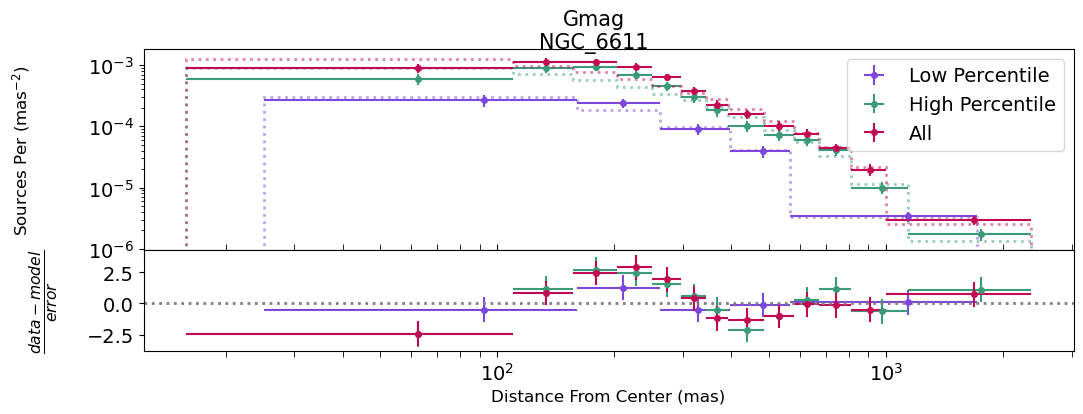

rho_free: p-value for our delta-chi-squared:  1.465979491480928e-59 for 2 fewer constraints.
rho, rc free: p-value for our delta-chi-squared:  0.3244315980492576 for 2 fewer constraints.
rho, rc, rt free: p-value for our delta-chi-squared:  0.05401227206161114 for 2 fewer constraints.


In [19]:
# To calculate the best-fitting model values, use the parameters of the best fit output
# from the fit, result.params and set output_resid=false to output a list of model y-values:
params = Parameters()
params.add_many(('rho_knot_1',1, True, 0, None),('c_1',1e-6,False, 0, None),('r_c_1', 500), ('r_t_1', 1000),
                ############################################################################################
                # second data set
                ('rho_knot_2',1, True, 0, None, ),('c_2',1e-6,False, 0, None, 'c_1'),
                ('r_c_2', 500, True, None, None,), ('r_t_2', 1000, True, None, None, ),
                #############################################################################################
                # third data set
                ('rho_knot_3',1, True, 0, None, ),('c_3',1e-6,False, 0, None, 'c_1'),('r_c_3', 500, True, None, None, ),
                ('r_t_3', 1000, True, None, None, ))

model_vals = lmf_lsq_binresid_mult(result_null.params,xdata,ydata,yerrs,model,output_resid=False)
# Now plot the data and model and residuals
legend_labels = ['Low Percentile', 'High Percentile', 'All']
plot_spec_model_mult(xdata,ydata,yerrs,model_vals,10,200,'weighted resid',legend_labels, title='Gmag')

m = result_all_fixed.nfree-result_rho_free.nfree
deltachisq = result_all_fixed.chisqr-result_rho_free.chisqr
print("rho_free: p-value for our delta-chi-squared: ",sps.chi2.sf(deltachisq,df=m),"for",m,"fewer constraints.")

m = result_rho_free.nfree-result_rho_rc_free.nfree
deltachisq = result_rho_free.chisqr-result_rho_rc_free.chisqr
print("rho, rc free: p-value for our delta-chi-squared: ",sps.chi2.sf(deltachisq,df=m),"for",m,"fewer constraints.")

m = result_rho_rc_free.nfree-result_rho_rc_rt_free.nfree
deltachisq = result_rho_rc_free.chisqr-result_rho_rc_rt_free.chisqr
print("rho, rc, rt free: p-value for our delta-chi-squared: ",sps.chi2.sf(deltachisq,df=m),"for",m,"fewer constraints.")

# Now we repeat the same process  for the other paramter IE abs_proper_motion 

In [20]:
####################################
# Now same but for other parameter



nbins = 50
# And now we use our new function to rebin so there are at least mincounts counts per bin:
mincounts = 20  # Here we set it to our minimum requirement of 20, but in principle you could set it higher

xdata = []  # We create empty lists to assign our binned spectra to lists for lmfit to fit them together
ydata = []
yerrs = []

for cluster_name in assigned_clusters[0:1]:
    #  First read in the data.  This is a simple (single-column) list of energies:

    # low range  gmag
    cluster_stars = stars_df[stars_df['Name'] == cluster_name]
    selected_percentile = cluster_stars[cluster_stars['abs_proper_motion_percentile_range'] == 'abs_proper_motion_low_percentile']['radial_separation_arcsec']


    counts, edges = np.histogram(selected_percentile, bins=nbins, density=False)
    counts2, edges2 = histrebin(mincounts,counts,edges)

    bins = edges2
    hist = counts2
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers = bin_centers
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  # this is wrong?
    #annulus_area = np.pi * np.diff(bins)**2
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area

    # not the count density, so we have to also apply the same normalisation.
    xdata.append(bins) # Now assign to our lists for lmfit
    ydata.append(stellar_density)
    yerrs.append(std_stellar_den) 

    print(' ')
    print('len xdata i ', len(bins))
    print('len ydata i ', len(stellar_density))
    print('len ydata err i ', len(std_stellar_den))

    # high range  gmag
    cluster_stars = stars_df[stars_df['Name'] == cluster_name]
    selected_percentile = cluster_stars[cluster_stars['abs_proper_motion_percentile_range'] == 'abs_proper_motion_high_percentile']['radial_separation_arcsec']


    counts, edges = np.histogram(selected_percentile, bins=nbins, density=False)
    counts2, edges2 = histrebin(mincounts,counts,edges)

    bins = edges2
    hist = counts2
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers = bin_centers
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  # this is wrong?
    #annulus_area = np.pi * np.diff(bins)**2
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area

    # not the count density, so we have to also apply the same normalisation.
    xdata.append(bins) # Now assign to our lists for lmfit
    ydata.append(stellar_density)
    yerrs.append(std_stellar_den) 

    print(' ')
    print('len xdata i ', len(bins))
    print('len ydata i ', len(stellar_density))
    print('len ydata err i ', len(std_stellar_den))


    # all data 
    cluster_stars = stars_df[stars_df['Name'] == cluster_name]
    selected_percentile = cluster_stars['radial_separation_arcsec']

    counts, edges = np.histogram(selected_percentile, bins=nbins, density=False)
    counts2, edges2 = histrebin(mincounts,counts,edges)

    bins = edges2
    hist = counts2
    bin_centers = (bins[:-1] + bins[1:]) / 2
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  # this is wrong?
    #annulus_area = np.pi * np.diff(bins)**2
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area

    # not the count density, so we have to also apply the same normalisation.
    xdata.append(bins) # Now assign to our lists for lmfit
    ydata.append(stellar_density)
    yerrs.append(std_stellar_den) 

    print(' ')
    print('len xdata i ', len(bins))
    print('len ydata i ', len(stellar_density))
    print('len ydata err i ', len(std_stellar_den))


 
len xdata i  7
len ydata i  6
len ydata err i  6
 
len xdata i  14
len ydata i  13
len ydata err i  13
 
len xdata i  14
len ydata i  13
len ydata err i  13


In [21]:
# Set params
# all params fixed to first data set
params = Parameters()
params.add_many(('rho_knot_1',1, True, 0, None),('c_1',1e-6,False, 0, None),('r_c_1', 500), ('r_t_1', 1000),
                ############################################################################################
                # second data set
                ('rho_knot_2',1, True, 0, None, 'rho_knot_1'),('c_2',1e-6,False, 0, None, 'c_1'),
                ('r_c_2', 500, True, None, None, 'r_c_1'), ('r_t_2', 1000, True, None, None, 'r_t_1'),
                #############################################################################################
                # third data set
                ('rho_knot_3',1, True, 0, None, 'rho_knot_1'),('c_3',1e-6,False, 0, None, 'c_1'),('r_c_3', 500, True, None, None, 'r_c_1'),
                ('r_t_3', 1000, True, None, None, 'r_t_1'))

# run
model = king_model_multi
output_resid = True
set_function = Minimizer(lmf_lsq_binresid_mult, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_all_fixed = set_function.minimize(method = 'leastsq')
result_null = result_all_fixed
print(' ', ' ', ' ', 'all params fixed')
report_fit(result_null)
print("Minimum Chi-squared = "+str(result_null.chisqr)+" for "+str(result_null.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result_null.chisqr,df=result_null.nfree))


# Set params
# rho knot is free
params = Parameters()
params.add_many(('rho_knot_1',1, True, 0, None),('c_1',1e-6,False, 0, None),('r_c_1', 500), ('r_t_1', 1000),
                ############################################################################################
                # second data set
                ('rho_knot_2',1, True, 0, None, ),('c_2',1e-6,False, 0, None, 'c_1'),
                ('r_c_2', 500, True, None, None, 'r_c_1'), ('r_t_2', 1000, True, None, None, 'r_t_1'),
                #############################################################################################
                # third data set
                ('rho_knot_3',1, True, 0, None, ),('c_3',1e-6,False, 0, None, 'c_1'),('r_c_3', 500, True, None, None, 'r_c_1'),
                ('r_t_3', 1000, True, None, None, 'r_t_1'))

# run
model = king_model_multi
output_resid = True
set_function = Minimizer(lmf_lsq_binresid_mult, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_rho_free = set_function.minimize(method = 'leastsq')
result_null = result_rho_free
print(' ', ' ', ' ', 'rho_knot is freed')
report_fit(result_null)
print("Minimum Chi-squared = "+str(result_null.chisqr)+" for "+str(result_null.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result_null.chisqr,df=result_null.nfree))


# Set params
# r_c is free
params = Parameters()
params.add_many(('rho_knot_1',1, True, 0, None),('c_1',1e-6,False, 0, None),('r_c_1', 500), ('r_t_1', 1000),
                ############################################################################################
                # second data set
                ('rho_knot_2',1, True, 0, None, ),('c_2',1e-6,False, 0, None, 'c_1'),
                ('r_c_2', 500, True, None, None,), ('r_t_2', 1000, True, None, None, 'r_t_1'),
                #############################################################################################
                # third data set
                ('rho_knot_3',1, True, 0, None, ),('c_3',1e-6,False, 0, None, 'c_1'),('r_c_3', 500, True, None, None, ),
                ('r_t_3', 1000, True, None, None, 'r_t_1'))
# run
model = king_model_multi
output_resid = True
set_function = Minimizer(lmf_lsq_binresid_mult, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_rho_rc_free = set_function.minimize(method = 'leastsq')
result_null = result_rho_rc_free
print(' ', ' ', ' ', 'r_c is freed')
report_fit(result_null)
print("Minimum Chi-squared = "+str(result_null.chisqr)+" for "+str(result_null.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result_null.chisqr,df=result_null.nfree))


# Set params
# rt is free
params = Parameters()
params.add_many(('rho_knot_1',1, True, 0, None),('c_1',1e-6,False, 0, None),('r_c_1', 500), ('r_t_1', 1000),
                ############################################################################################
                # second data set
                ('rho_knot_2',1, True, 0, None, ),('c_2',1e-6,False, 0, None, 'c_1'),
                ('r_c_2', 500, True, None, None,), ('r_t_2', 1000, True, None, None, ),
                #############################################################################################
                # third data set
                ('rho_knot_3',1, True, 0, None, ),('c_3',1e-6,False, 0, None, 'c_1'),('r_c_3', 500, True, None, None, ),
                ('r_t_3', 1000, True, None, None, ))

# run
model = king_model_multi
output_resid = True
set_function = Minimizer(lmf_lsq_binresid_mult, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_rho_rc_rt_free = set_function.minimize(method = 'leastsq')
result_null = result_rho_rc_rt_free

print(' ', ' ', ' ', 'All params free')
report_fit(result_null)
print("Minimum Chi-squared = "+str(result_null.chisqr)+" for "+str(result_null.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result_null.chisqr,df=result_null.nfree))

      all params fixed
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 32
    # variables        = 3
    chi-square         = 369.532985
    reduced chi-square = 12.7425167
    Akaike info crit   = 84.2881313
    Bayesian info crit = 88.6853390
[[Variables]]
    rho_knot_1:  6.4033e-04 +/- 1.6693e-04 (26.07%) (init = 1)
    c_1:         1e-06 (fixed)
    r_c_1:       279.800182 +/- 91.9692245 (32.87%) (init = 500)
    r_t_1:       1630.92914 +/- 390.817786 (23.96%) (init = 1000)
    rho_knot_2:  6.4033e-04 +/- 1.6693e-04 (26.07%) == 'rho_knot_1'
    c_2:         1.0000e-06 +/- 0.00000000 (0.00%) == 'c_1'
    r_c_2:       279.800182 +/- 91.9692247 (32.87%) == 'r_c_1'
    r_t_2:       1630.92911 +/- 390.817786 (23.96%) == 'r_t_1'
    rho_knot_3:  6.4033e-04 +/- 1.6693e-04 (26.07%) == 'rho_knot_1'
    c_3:         1.0000e-06 +/- 0.00000000 (0.00%) == 'c_1'
    r_c_3:       279.800182 +/- 91.9692247 (32.87%) == 'r_c_1'
    r_t_3:    

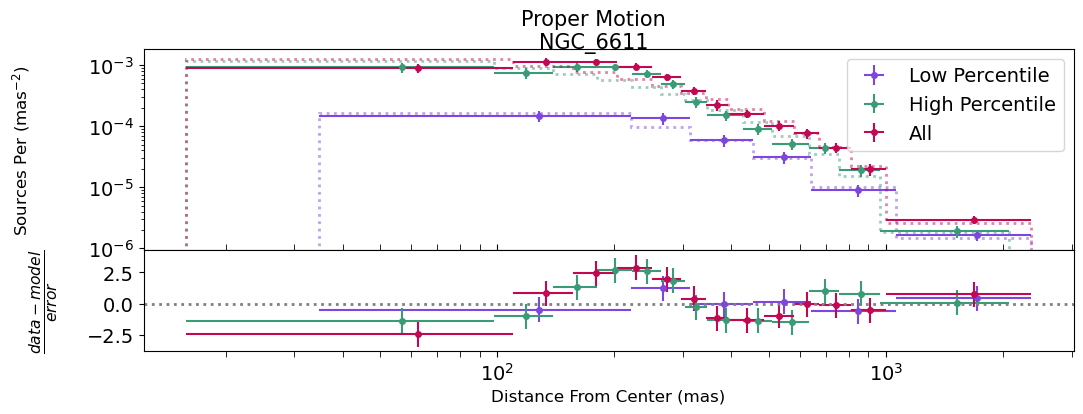

rho_free: p-value for our delta-chi-squared:  9.247875476009352e-65 for 2 fewer constraints.
rho, rc free: p-value for our delta-chi-squared:  0.005219692798236226 for 2 fewer constraints.
rho, rc, rt free: p-value for our delta-chi-squared:  0.2810604202956338 for 2 fewer constraints.


In [22]:
# To calculate the best-fitting model values, use the parameters of the best fit output
# from the fit, result.params and set output_resid=false to output a list of model y-values:
params = Parameters()
params.add_many(('rho_knot_1',1, True, 0, None),('c_1',1e-6,False, 0, None),('r_c_1', 500), ('r_t_1', 1000),
                ############################################################################################
                # second data set
                ('rho_knot_2',1, True, 0, None, ),('c_2',1e-6,False, 0, None, 'c_1'),
                ('r_c_2', 500, True, None, None,), ('r_t_2', 1000, True, None, None, ),
                #############################################################################################
                # third data set
                ('rho_knot_3',1, True, 0, None, ),('c_3',1e-6,False, 0, None, 'c_1'),('r_c_3', 500, True, None, None, ),
                ('r_t_3', 1000, True, None, None, ))

model_vals = lmf_lsq_binresid_mult(result_null.params,xdata,ydata,yerrs,model,output_resid=False)
# Now plot the data and model and residuals
legend_labels = ['Low Percentile', 'High Percentile', 'All']
plot_spec_model_mult(xdata,ydata,yerrs,model_vals,10,200,'weighted resid',legend_labels, title='Proper Motion')

m = result_all_fixed.nfree-result_rho_free.nfree
deltachisq = result_all_fixed.chisqr-result_rho_free.chisqr
print("rho_free: p-value for our delta-chi-squared: ",sps.chi2.sf(deltachisq,df=m),"for",m,"fewer constraints.")

m = result_rho_free.nfree-result_rho_rc_free.nfree
deltachisq = result_rho_free.chisqr-result_rho_rc_free.chisqr
print("rho, rc free: p-value for our delta-chi-squared: ",sps.chi2.sf(deltachisq,df=m),"for",m,"fewer constraints.")

m = result_rho_rc_free.nfree-result_rho_rc_rt_free.nfree
deltachisq = result_rho_rc_free.chisqr-result_rho_rc_rt_free.chisqr
print("rho, rc, rt free: p-value for our delta-chi-squared: ",sps.chi2.sf(deltachisq,df=m),"for",m,"fewer constraints.")

### 3 Comments:

note to self: The p-value is basically the probability that you would see this decrease in chisqr after freeing up rho_knot, if actually the null-hypothesis (that your data is independent of rho_knot)  is true


for both parameters the results were similar!
- Based on the p-values reported, we rule out the null-hypothesis for rho_knot! at 5> sigma, aka the different data sets have different rho_knot values!
- the null hypothesis does not rule out rc, or rt. 


##Conclusion: 
The fited data is consistent whith different values of rho_knot for the different data sets for both variables. The other 2 paramters, rc, and rt appear to be the same for the different data sets for both parameters (gmag, and proper motion)

This makes sense, as looking at the plot, visually the low percentile appears to have a different normalization value (rho_knot) but otherwize follow the same data model trends. Perhaps the low percentile data set has far less stars (and hence stellar denstiy) then the high percentile, and complete data sets







# Part 4:

Making some plausible assumptions about the mass distribution in the cluster, we can use the virial
theorem1 to estimate the mass � of the cluster as follows:

$$ M = \frac{3 r_c <\sigma_{pm}^2>}{2G}$$

where � is the gravitational constant, �0 is the cluster core radius and 〈�pm
! 〉 is the population mean of
the squared-velocity dispersion of the cluster stars which can be measured from the sample variance
of the cluster stars proper motions2
. To calculate the mass, these need to be turned into the correct
physical units, using the distance to the cluster �.


Use Bayes’ theorem to write out the equation relating the posterior distribution of mass � to the
likelihood of the data given the parameters �0, � and 〈�pm
! 〉. Then use MCMC to fit the complete
dataset for one of your clusters (your choice) with appropriate priors on �, �0, � and 〈�pm
! 〉 and use
the results to obtain the MLE and 1-� confidence interval on the mass. Be sure to calculate the mass
in physical units (kg, g or solar masses are all fine) and be careful to explain your reasoning and state
your assumptions clearly!

### Idea:

We follow closely lesson 12, like a paint by numbers kit and hope for the best. We will need to make yet again a new model function, this time lets call it king_model_mcmc


First:
* Rewrite equation so we have $r_c$!, we checked with dimensionaly analysis and we need a factor of distance^3 for our units to make sense, we identify this as the distance to the cluster. 
    - $ r_c = \frac{2G}{3D^3<\sigma_{pm}^2>}$

* we will use $\sigma_{pm}^2 = \sigma_{pmra}^2 + \sigma_{pmdec}^2$, with  $\sigma_{pmra}$ given by the standard deviation for the cluster of PM in ra
* we will use last weeks code + high prob only to estimate the distance for our prior




### Assumptions:

priors are the fitted model parems from part 2, mass prior is mass of sun * n stars in cluster, D prior is distance calucalted in a2, sigma_pm2 is calculated as above
other assumptions as before



In [23]:
# copied from lessons

def LogLikelihood_Pois(model_counts, counts): 
    '''Calculate the negative Poisson log-likelihood for a model vs counts data. 
       Inputs:
           model_counts - array of predicted model counts per bin
           counts - data: observed counts per bin.
        Outputs: the negative Poisson log-likelihood'''
    pd = sps.poisson(model_counts) #we define our Poisson distribution
    return -1*np.sum(pd.logpmf(counts))

def lmf_poissll(params,xdata,ydata,model,output_ll=True):
    '''lmfit objective function to calculate and return total negative Poisson log-likelihood or model 
        y-values for binned data where the xdata are the contiguous (i.e. no gaps) input bin edges and 
        ydata are the counts (not count densities) per bin.
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y counts density array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (total -ve 
                        log-likelihood) is required output, otherwise a list of model y-value arrays 
                        (corresponding to the input x-data list) is returned.
        Output: if output_resid==True, returns the total negative log-likelihood. If output_resid==False, 
                returns a list of y-model counts density arrays (one per input x-array)'''
    if output_ll == True:
        poissll = 0
        for i, xvals in enumerate(xdata):  # loop through each input dataset to sum negative log-likelihood
                # We can re-use our model binning function here, but the model then needs to be converted into 
                # counts units from counts density, by multiplying by the bin widths
                ymodel = model_bin(xdata[i],model,params)*np.diff(xdata[i])
                # Then obtain negative Poisson log-likelihood for data (in counts units) vs the model 
                poissll = poissll + LogLikelihood_Pois(ymodel,ydata[i])
        return poissll
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel


def lmf_poissll_emcee(params,xdata,ydata,model,prior_model,output_ll=True):
    '''lmfit-style objective function to calculate and return total Poisson log-likelihood or model 
        y-values for binned data where the xdata are the contiguous (i.e. no gaps) input bin edges and 
        ydata are the counts (not count densities) per bin.
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y counts density array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (total -ve 
                        log-likelihood) is required output, otherwise a list of model y-value arrays 
                        (corresponding to the input x-data list) is returned.
        Output: if output_resid==True, returns the total negative log-likelihood. If output_resid==False, 
                returns a list of y-model counts density arrays (one per input x-array)'''
    if output_ll == True:
        poissll = 0
        for i, xvals in enumerate(xdata):  # loop through each input dataset to sum negative log-likelihood
                # We can re-use our model binning function here, but the model then needs to be converted into 
                # counts units from counts density, by multiplying by the bin widths
                ymodel = model_bin(xdata[i],model,params)*np.diff(xdata[i])
                # Then obtain negative Poisson log-likelihood for data (in counts units) vs the model 
                poissll = poissll + (-1*LogLikelihood_Pois(ymodel,ydata[i]))
        poissll_prior = poissll + prior_model(params)     
        if not np.isfinite(poissll_prior):
            return -np.inf
        else:
            return poissll_prior
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel

def model_bin(xbins, model, params):
    '''General function for integrating the input model over bins defined by contiguous (no gaps) 
        bin edges, xbins.
       Inputs:
           xbins - x bin edges.
           model, params - the model name and associated Parameters object.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(xbins)-1)
    for i, xval in enumerate(xbins[:-1]):
        ymod[i], ymoderr = spint.quad(lambda x: model(x, params),xbins[i],xbins[i+1])
        ymod[i] = ymod[i]/(xbins[i+1]-xbins[i])  # we now divide by the bin width to match the counts density
        # units of our data
    return ymod

def LogLikelihood_Pois(model_counts, counts): 
    '''Calculate the negative Poisson log-likelihood for a model vs counts data. 
       Inputs:
           model_counts - array of predicted model counts per bin
           counts - data: observed counts per bin.
        Outputs: the negative Poisson log-likelihood'''
    pd = sps.poisson(model_counts) #we define our Poisson distribution
    return -1*np.sum(pd.logpmf(counts))
        
def plexp_model_emcee(x, pars):
    '''Power-law function with an exponential cut-off.
       Inputs:
           x - input x value(s) (can be list or single value).
           pars - parameters, list of PL normalisation (at x = 1) and power-law index.'''
    (N,gamma,E_cut) = pars
    return N*(x**gamma)*np.exp(-1*x/E_cut)
    
def plexp_logprior(pars):
    '''returns the combined log-prior for the given input pars. Here we assume a uniform
    within specified limits, and zero probability (-ve infinity log-p) otherwise.'''
    (N,gamma,E_cut) = pars
    if ((N <= 0) | (E_cut > 20) | (E_cut <= 0)):
        return -np.inf
    else:
        return 0

In [24]:
# calculate sigma_pm_2

cluster_name = assigned_clusters[1]
part_4df = stars_df[stars_df['Name'] == cluster_name]
part_4df
one_cluster_df = part_4df

sigma_pmra = one_cluster_df['pmRA'].std()
sigma_pmdec = one_cluster_df['pmDE'].std()

sigma_pm_2 = sigma_pmra**2 + sigma_pmdec**2


In [25]:
# code from a2 used to option the D prior, 
# lets make a function version 
# I had help from Hugo, Jonas in making this function, but it is based on the online lessons
def bayesian_analysis_distance(cluster_df, cluster_name, prior_type='uniform',
                               plot=True, print_results=True, color='red', 
                               label='label', linestyle='-'):
    
    """
    Perform Bayesian analysis to estimate the distance to a star cluster based on parallax measurements.

    Parameters:
    - cluster_df (pandas df): Data frame of all clusters, needs e_plx, plx, name cols
    - cluster_name (str): Name of the star cluster for labeling the plot and results.
    - prior_type (str, optional): Type of prior distribution. Options are 'uniform' (default) or 'exp'.
    - plot (bool, optional): If True, plot the posterior probability density function. Default is True.
    - print_results (bool, optional): If True, print the results including integral value, maximum likelihood
      position, and 1-sigma confidence interval. Default is True.
    - color (str, optional): Color of the plot line. If None, a default color will be used.
    - label (str, optional): Label for the plot legend. If None, no label will be added.
    - linestyle (str, optional): Line style of the plot. If None, a default style will be used.

    Returns:
    - dist_arr (array): Array of distance values used in the analysis.
    - posterior_pdf (array): Posterior probability density function for the distance.
    - max_likelihood_position (float): Maximum likelihood position of the distance.
    - int95 (array): 1-sigma confidence interval for the distance.

    Note:
    - The function uses a Bayesian approach with either a uniform or exponential prior to estimate the posterior
      probability density function for the distance to the star cluster.
    - The plot displays the posterior probability density function if `plot` is set to True.
    - Results including the integral value, maximum likelihood position, and 1-sigma confidence interval are printed
      if `print_results` is set to True.
    """

    plx = cluster_df[cluster_df['Name'] == cluster_name]['Plx'].values
    e_plx = cluster_df[cluster_df['Name'] == cluster_name]['e_Plx'].values
    my_stars_plx = plx + gaia_corr # Adding correction factor

    # Create a grid of 1000 values of lambda to calculate the posterior over:
    # we are going a bit under and a bit over the min and max values
    dist_arr = np.linspace(0.8 / np.max(my_stars_plx ), 1.2 / np.min(my_stars_plx ), int(1e3))

    # Set parameters for log-normal distribution
    x = my_stars_plx.reshape(len(my_stars_plx),1)
    scale = e_plx.reshape(len(x), 1)
    loc = 1/(dist_arr.reshape(1, len(dist_arr)))

    # Calculate Prior
    if prior_type == 'uniform':
        prior = 1 * np.ones(len(dist_arr))
        
    if prior_type == 'exp':
        prior = (dist_arr)**2 * np.exp(-dist_arr)

    # Calculate log-likelihood * prior for  distribution
    # this is the numerator in Baye's   formula
    loglikel_ln = np.sum(sps.norm.logpdf(x=x, scale=scale, loc=loc,), axis=0)+ np.log(prior)

    likel_ln = np.exp(loglikel_ln ) # convert back from log space

    # Calculate denominator for Baye's formula
    likel_ln_int = spint.simpson(likel_ln, dist_arr, axis=0)

    # Now we normalize and we have our posterior pdf 
    posterior_pdf = likel_ln  / likel_ln_int

    # Find Maximum Likelihood Position
    max_likelihood_position = dist_arr[np.argmax(posterior_pdf)]

    # Calculate 1-Sigma Confidence Interval
    # Calculate 95% confidence interval. The range must be 0.95, centred on 0.5 (the median)
    posterior_cdf = spint.cumulative_trapezoid(posterior_pdf,dist_arr,initial=0)
    posterior_ppf = spinterp.interp1d(posterior_cdf,dist_arr)
    int95 = posterior_ppf([0.025,0.975])


    # plotting
    if plot == True:
        
        plt.plot(dist_arr, posterior_pdf, color=color, label=label, linestyle=linestyle, alpha=0.5, linewidth=3)
        # Add vertical line for mode
        plt.axvline(max_likelihood_position, linestyle='-.', color='k', alpha=0.5, label='Mode:' + label, linewidth=3)

        # Add vertical lines for 1 sigma 
        plt.axvline(int95[0], linestyle=':', color='green', label='1-Sigma Confidence Interval', alpha=0.5, linewidth=3)
        plt.axvline(int95[1], linestyle=':', color='green', alpha=0.5, linewidth=3)
        # Legend and plotting garb
        plt.legend(fontsize=12)
        plt.xlabel(r'Distance (Kpc)', size=15)
        plt.ylabel(r'Posterior pdf (prob/Kpc)', size=15)
        plt.title(cluster_name + '\n N = ' + str(len(plx)),  size=15)
        plt.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)

        # x lim
        plt.xlim (0.9 * int95[0], 1.1*int95[1])
       


    # Print results
    if print_results == True:
        print(label)
        # Calculate the integral using the trapezoidal rule
        integral_value = simps(posterior_pdf, dist_arr)
        print("Posterior pdf Integral value:", integral_value)
        print("Maximum Likelihood Position:", max_likelihood_position, ' Kpc')
        print("1-Sigma Confidence Interval:" ,int95, ' Kpc')
        print('\n')

    # Return 
    return dist_arr, posterior_pdf, max_likelihood_position, int95

['NGC_6611', 'NGC_1817', 'NGC_663']
Exp Prior
Posterior pdf Integral value: 1.0
Maximum Likelihood Position: 1.6592980641846262  Kpc
1-Sigma Confidence Interval: [1.65127088 1.66833078]  Kpc




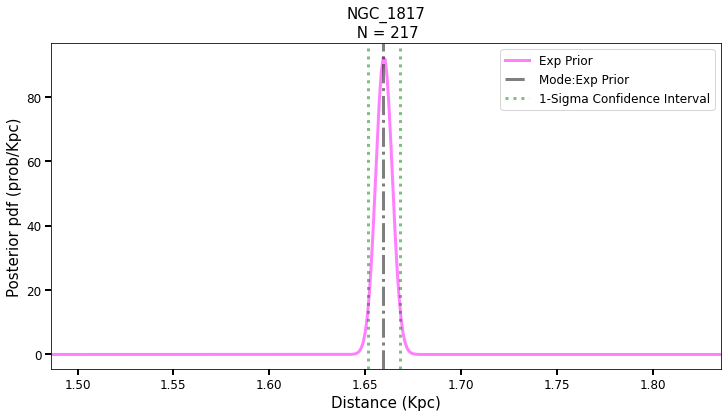

In [26]:
cluster_name = assigned_clusters[1]
print(assigned_clusters)

distance_df = stars_df[stars_df['Prob']>0.8] # some low prob stars throw it off

plt.figure(figsize=(12,6))
color='magenta'
label='Exp Prior'
linestyle='-'
prior_type ='exp'
dist_arr, posterior_pdf, max_likelihood_position, int95 = bayesian_analysis_distance(cluster_df=distance_df, cluster_name=cluster_name, prior_type='exp',
                                   plot=True, print_results=True, color=color, 
                                   label=label, linestyle=linestyle)

In [27]:
D = max_likelihood_position *1000 * parsec_to_m 
# max_ postion is in Kpc, so we need to convert by 1000, to get pc, and then parsec to km

Now we will set up the sampler. 

We first need to set up the starting positions of the walkers in the n-dimensional parameter space, which will roam the likelihood surface 

In [45]:
# generate some data

source_distance = stars_df[stars_df['Name'] == cluster_name]['radial_separation_arcsec'] # arcsec

hist, bins = np.histogram(source_distance, bins=nbins)  # Adjust the number of bins as needed
                                                                                      # Using SQRT of n rule for the moment
    
# rebin the data 
hist, bins = histrebin(mininbin=20,counts=hist,edges=bins)
counts2, edges2 = histrebin(mincounts,hist,bins)

bins = edges2
hist = counts2
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers = bin_centers
annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  # this is wrong?
#annulus_area = np.pi * np.diff(bins)**2
stellar_density = (hist/ annulus_area)
std_stellar_den = np.sqrt(hist) / annulus_area

# not the count density, so we have to also apply the same normalisation.
xdata = [bins] # Now assign to our lists for lmfit
ydata = [stellar_density]
yerr = [std_stellar_den] 


In [46]:
# copied code from MCMC lesson 
# modified for our purposes 


# Given parameter values these are from the model fit performed in part 2
rho_knot_value = 7.6055e-04
c_value = 8.6519e-07
r_t_value = 2314.53197
M_value = mass_sun_kg * 718 # (mass of sun * number of stars in cluster)


# Create a list of values in the specified order
parameter_values = [rho_knot_value, c_value, r_t_value, M_value, D, sigma_pm_2]

best_par_list = parameter_values

best_par=np.array(best_par_list) # needs to be an array so we can use it for calculations
ndim, nwalkers = len(best_par_list), 100  # The number of parameters and the number of walkers (we follow the 
# emcee example and use 100)
output_ll=True
pos = [best_par + 0.01*best_par*sps.norm.rvs(size=ndim) for i in range(nwalkers)]  # we spread the 
# walkers around the MLEs with a standard deviation equal to 1 per cent of the MLE value

### From the lesson

Now we are ready to run the MCMC ‘sampler’ which lets the walkers map the likelihood surface. Since we are using emcee as a standalone method, we need to modify our function to work with parameters expressed in a tuple rather than an lmfit parameters object. emcee also maximises log-likelihoods, so we should also change the output to be log-likelihood rather than 
−
1
×
log-likelihood, which was needed for fitting by optimisers such as lmfit (which seek to minimize functions).

We will also make our approach more Bayesian by incorporating priors in the probability estimate, so that we are sampling from the posterior distribution. Since we are using log-likelihood, these should also be expressed as a logarithm (they are thus sometimes known as log-priors). The prior can be used to constrain the ranges of allowed parameter values to those that are previously determined from different data sets, or it could also be neglected (this is equivalent to assuming a uniform prior from 
−
∞
 to 
+
∞
, i.e. no preference at all about what values the prior should take). Priors may also follow other distributions: read a Bayesian statistics book for more details. The prior should not be used to constrain parameters such that they cut off the true parameter distributions (i.e. don’t use prior boundaries that are comparable to a few times the parameter error bar or less). If in doubt, use a constant log-prior which is set to zero across the parameter space.

### Yet again, we need to make a new model fuction this time, one that takes in tuples

In [47]:


def lmf_poissll_emcee(params,xdata,ydata,model,prior_model,output_ll=True):
    '''lmfit-style objective function to calculate and return total Poisson log-likelihood or model 
        y-values for binned data where the xdata are the contiguous (i.e. no gaps) input bin edges and 
        ydata are the counts (not count densities) per bin.
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y counts density array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (total -ve 
                        log-likelihood) is required output, otherwise a list of model y-value arrays 
                        (corresponding to the input x-data list) is returned.
        Output: if output_resid==True, returns the total negative log-likelihood. If output_resid==False, 
                returns a list of y-model counts density arrays (one per input x-array)'''
    if output_ll == True:
        poissll = 0
        for i, xvals in enumerate(xdata):  # loop through each input dataset to sum negative log-likelihood
                # We can re-use our model binning function here, but the model then needs to be converted into 
                # counts units from counts density, by multiplying by the bin widths
                ymodel = model_bin(xdata[i],model,params)*np.diff(xdata[i])
                # Then obtain negative Poisson log-likelihood for data (in counts units) vs the model 
                poissll = poissll + (-1*LogLikelihood_Pois(ymodel,ydata[i]))
        poissll_prior = poissll + prior_model(params)     
        if not np.isfinite(poissll_prior):
            return -np.inf
        else:
            return poissll_prior
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel

def model_bin(xbins, model, params):
    '''General function for integrating the input model over bins defined by contiguous (no gaps) 
        bin edges, xbins.
       Inputs:
           xbins - x bin edges.
           model, params - the model name and associated Parameters object.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(xbins)-1)
    for i, xval in enumerate(xbins[:-1]):
        ymod[i], ymoderr = spint.quad(lambda x: model(x, params),xbins[i],xbins[i+1])
        ymod[i] = ymod[i]/(xbins[i+1]-xbins[i])  # we now divide by the bin width to match the counts density
        # units of our data
    return ymod

def LogLikelihood_Pois(model_counts, counts): 
    '''Calculate the negative Poisson log-likelihood for a model vs counts data. 
       Inputs:
           model_counts - array of predicted model counts per bin
           counts - data: observed counts per bin.
        Outputs: the negative Poisson log-likelihood'''
    pd = sps.poisson(model_counts) #we define our Poisson distribution
    return -1*np.sum(pd.logpmf(counts))
        
def plexp_model_emcee(x, pars):
    '''Power-law function with an exponential cut-off.
       Inputs:
           x - input x value(s) (can be list or single value).
           pars - parameters, list of PL normalisation (at x = 1) and power-law index.'''
    (N,gamma,E_cut) = pars
    return N*(x**gamma)*np.exp(-1*x/E_cut)
    
def plexp_logprior(pars):
    '''returns the combined log-prior for the given input pars. Here we assume a uniform
    within specified limits, and zero probability (-ve infinity log-p) otherwise.'''
    (N,gamma,E_cut) = pars
    if ((N <= 0) | (E_cut > 20) | (E_cut <= 0)):
        return -np.inf
    else:
        return 0

#### Now run mcmc 

In [48]:


def king_model_mcmcv2(x, params):
    r = x

    # print(params)
   # (rho_knot, c, r_t, M, sigma_pm_2) = params
    (rho_knot, c, r_t, M, D, sigma_pm_2) = params
    
    '''
    param_values = {}
    for param_name in params.keys():
        param_values[param_name] = params[param_name].value if isinstance(params[param_name], lmfit.Parameter) else params[param_name]

    # Now, you can access individual parameter values using param_values dictionary
    rho_knot = param_values['rho_knot']
    c = param_values['c']
    M = param_values['M']
    D = param_values['D'] # in units of km 
    r_t = param_values['r_t']
    sigma_pm_2 = param_values['sigma_pm_2']

 
    rho_knot = params['rho_knot'].value
    c = params['c'].value
    r_t = params['r_t'].value
    M = params['M'].value
    D = params.['D'].value
    sigma_pm_2 = params['sigma_pm_2'].value

    '''

    r_c = ((2/3) * G *M )/ (sigma_pm_2 * D**3)
        
    # Check if all parameters are numeric
    if not all(isinstance(param, (int, float)) for param in [rho_knot, c, r_c, r_t]):
        print('error in function')
        raise ValueError("All parameters must be numeric.")
    
    # Perform calculations
    frac1 = 1 / np.sqrt(1 + (r / r_c)**2)
    frac2 = 1 / np.sqrt(1 + (r_t / r_c)**2)
    rho_king = rho_knot * (frac1 - frac2)**2 + c
    
    # Use boolean indexing to set values for r > r_t if rho_king is a NumPy array
    if isinstance(rho_king, np.ndarray):
        rho_king[r > r_t] = c

    else:
        if r > r_t:
            rho_king = c
    
    return rho_king


In [49]:
def king_model_logprior(params):
    '''Returns the combined log-prior for the given input parameters. Assumes uniform
    within specified limits, and zero probability (-ve infinity log-p) otherwise.'''
    (rho_knot, c, r_t, M, D, sigma_pm_2) = params
    if any(param <= 0 for param in [rho_knot, c, r_t, M, D, sigma_pm_2]):
        return -np.inf
    else:
        return 0

In [50]:


model = king_model_mcmcv2
prior_model = king_model_logprior
sampler = emcee.EnsembleSampler(nwalkers, ndim, lmf_poissll_emcee, 
                                args=(xdata,ydata,model,prior_model,output_ll),pool=Pool())
sampler.run_mcmc(pos, 10000)

np.save('plexp1000_samplerchain',sampler.chain)

/home/afinemax/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


/tmp/ipykernel_2435176/2467248864.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


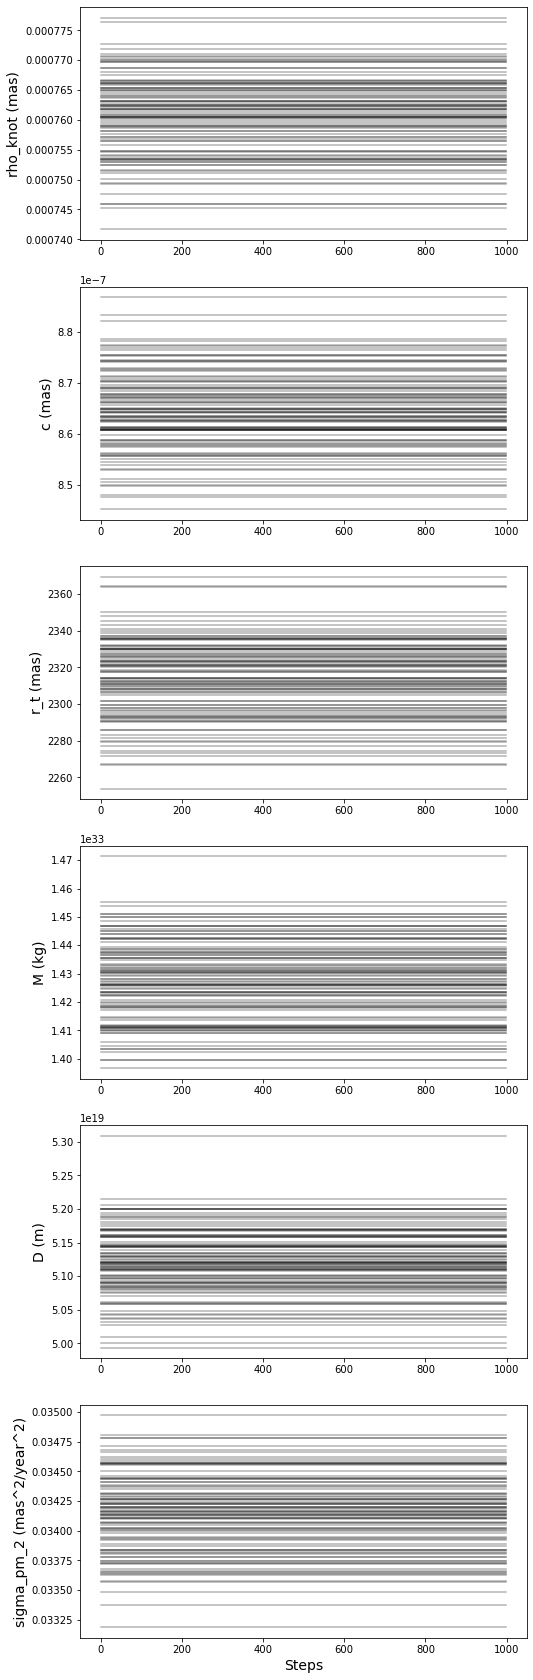

In [57]:
labels_list = ['rho_knot (mas)', 'c (mas)', 'r_t (mas)', 'M (kg)', 'D (m)', 'sigma_pm_2 (mas^2/year^2)'] # labels for our plots

nsteps = 1000  # How many steps to plot. We plot fewer steps since we include all walkers.
fig = plt.figure(figsize = (8, 30))
fig.clf()
for j in range(ndim):
    ax = fig.add_subplot(ndim,1,j+1)
    for k in range(nwalkers):
        ax.plot(sampler.chain[k,:nsteps,j],color='black',alpha = 0.3)
    ax.set_ylabel(labels_list[j], fontsize = 14)
plt.xlabel('Steps', fontsize = 14)
plt.savefig('ep12_allchains_plexpcut_1000cts.png')
fig.show()

### Comment on Plot

Well, the MCMC walkers look very flat which is in some ways good, there not sproadically moving over paramter space as N steps increases and they appear to have settled down very quickly. This settling down is good.

The bad news is that it looks like a bar-code, the walkers appear to have settled on different paraemter values, and stayed there. This is a bad sign as we want the values of the walkers to converge. 

/tmp/ipykernel_2435176/2487832929.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


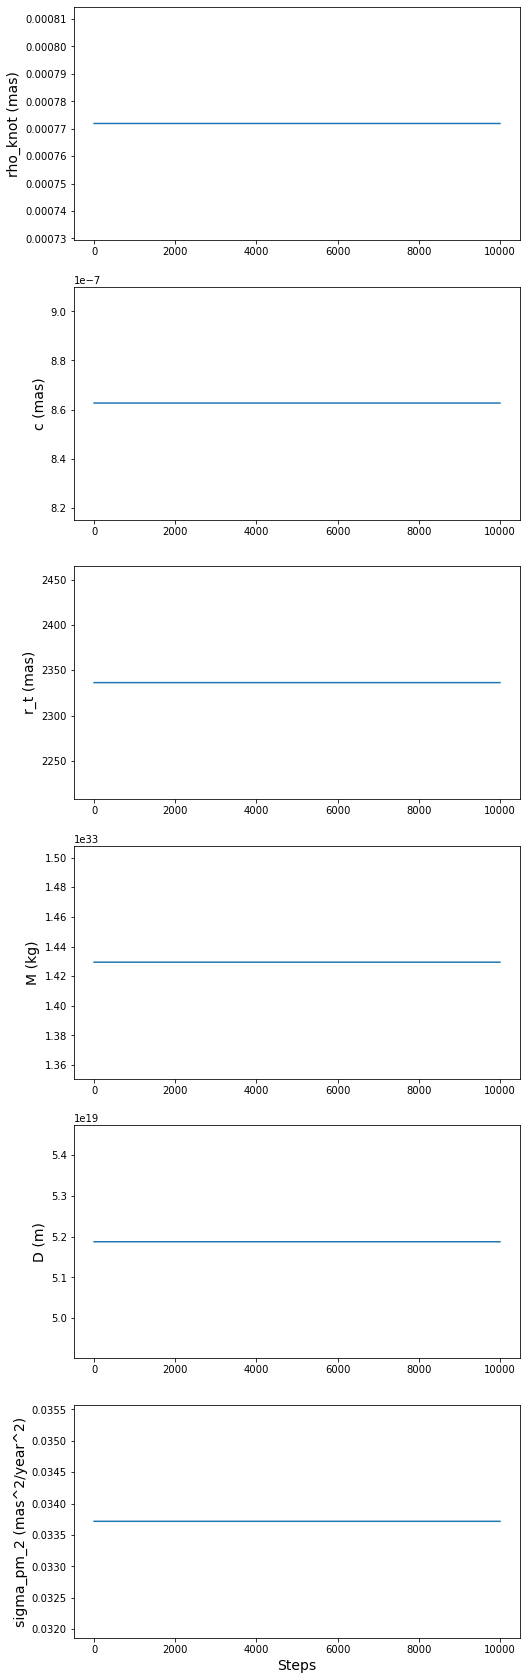

In [58]:
nsteps = 10000  # How many steps to plot
rng = np.random.default_rng()  # Set up a random number generator to select a random walker
fig = plt.figure(figsize = (8, 30))
fig.clf()
for j in range(ndim):
    ax = fig.add_subplot(ndim,1,j+1)
    ax.plot(sampler.chain[rng.integers(nwalkers),:nsteps,j]) # plot the chain for a random walker
    ax.set_ylabel(labels_list[j], fontsize = 14)
plt.xlabel('Steps', fontsize = 14)
plt.savefig('ep12_singlechain_plexpcut_1000cts.png')
fig.show()

### Comment on above plot
it looks extremely flat!, very little movement if any. Perhaps the walkers are staying close by the values they started at

In [59]:
import scipy.fft

/home/afinemax/anaconda3/lib/python3.9/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


Autocorrelation scales (in steps):  [nan nan nan nan nan nan]


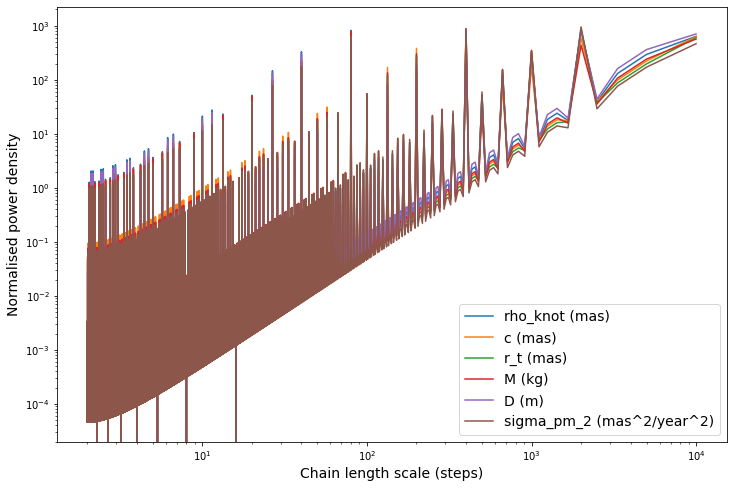

In [62]:
tau = sampler.get_autocorr_time()  # include parameter quiet=False if the function fails due to 
                                    # chains not being long enough
print("Autocorrelation scales (in steps): ",tau)

def plot_chains_powspec(chain_in,labels): 
    powspec = np.sum(np.abs(scipy.fft.fft(chain_in,axis=1))**2,axis=0)
    freq = scipy.fft.fftfreq(len(chain_in[0,:,0]))
    plt.figure(figsize=(12,8))
    for i in range(ndim):
        plt.plot(1/freq[1:len(freq)//2],
                 powspec[1:len(freq)//2,i]/np.mean(powspec[1:len(freq)//2,i]),label=labels[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Chain length scale (steps)', fontsize = 14)    
    plt.ylabel(r'Normalised power density', fontsize = 14)
    plt.legend(fontsize=14)
    plt.savefig('ep12_chains_powspec.png')
    plt.show()
    return

plot_chains_powspec(sampler.chain,labels_list)

### Comment on above plot
Not sure what this means, looks like    

For short length scales, the power spectrum has the characteristic shape of a random walk (power-law slope is -2 for power vs. frequency). Unlike the example code, our spectrum does not flatten out at high nsteps perhaps indicative that I need to run more steps or something is wrong. If it flattened out it would indicate " uncorrelated ‘white noise’ on those length scales. The flattening scale provides a more conservative estimate of the `burn-in’ length of the chain, as well as how many indicating truly independent samples are in the chain" quote from example but it still applies

it is not flattening out even at $10^4$ steps!

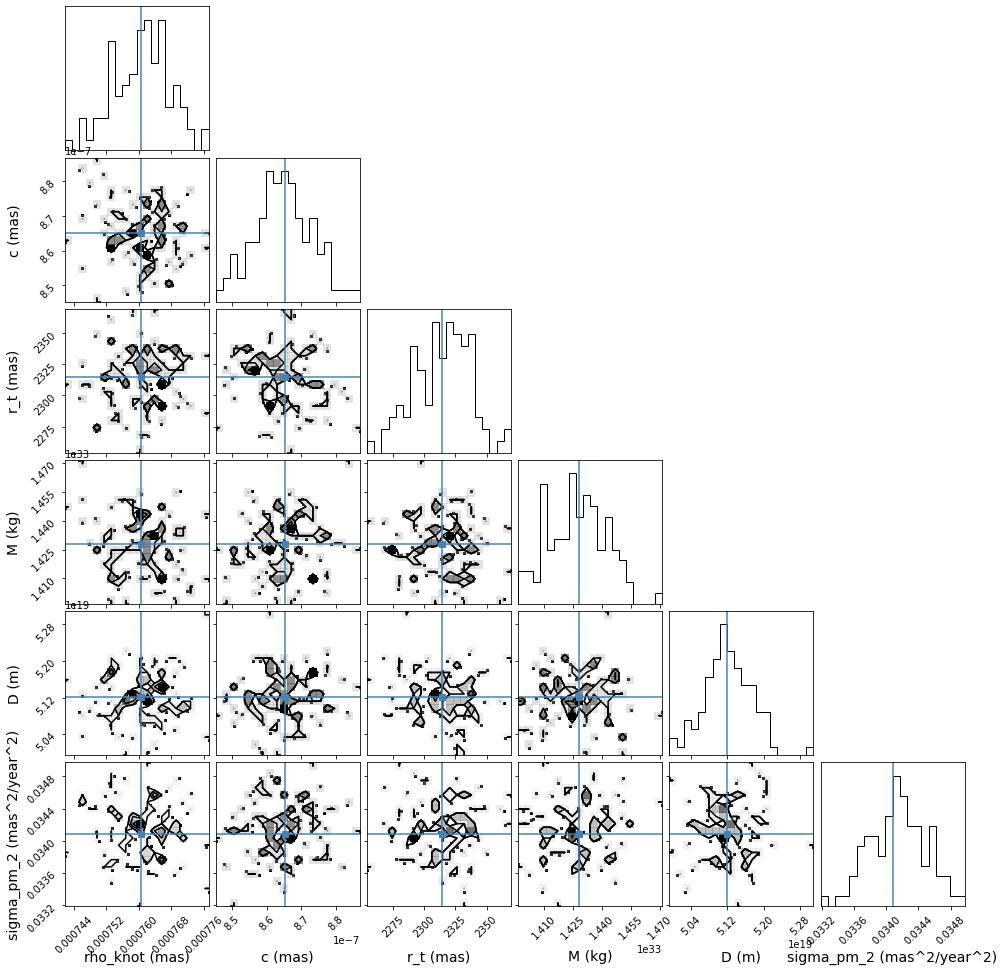

In [63]:
# Plot a corner plot using thin=10 to reduce the density for visual appearance
flat_samples = sampler.get_chain(discard=5000, thin=10, flat=True) 
fig = corner.corner(flat_samples, labels=labels_list, label_kwargs={"fontsize": 14}, truths=parameter_values)
plt.savefig('ep12_corner_plexpcut_1000cts.png')
plt.show()

In [64]:
labels_list = ['rho_knot (mas)', 'c (mas)', 'r_t (mas)', 'M (kg)', 'D (m)', 'sigma_pm_2 (mas^2/year^2)']  # labels for our plots

flat_samples_full = sampler.get_chain(discard=5000, flat=True)
print("Median and 1-sigma errors")
for i in range(ndim):
    mcmc = np.percentile(flat_samples_full[:, i], [15.85, 50, 84.15])
    q = np.diff(mcmc)
    txt = "{3} = {0} -{1}/+ {2}"  # Removed the rounding to 3 decimal places.
    txt = txt.format(mcmc[1], q[0], q[1], labels_list[i])
    print(txt)

Median and 1-sigma errors
rho_knot (mas) = 0.0007611330954280536 -7.911937097590267e-06/+ 6.314857178717974e-06
c (mas) = 8.643586308805022e-07 -8.377245488953618e-09/+ 9.734198944500979e-09
r_t (mas) = 2314.3997916593253 -23.51879117760427/+ 21.188176315611145
M (kg) = 1.4276914981777158e+33 -1.6804116722547448e+31/+ 1.6110842016209999e+31
D (m) = 5.119829419613979e+19 -4.4367786678092595e+17/+ 4.985393112497275e+17
sigma_pm_2 (mas^2/year^2) = 0.03415962414342857 -0.0004147782978832226/+ 0.0003920045775008263


# part 4 comment

I think the MCMC walkers are stationary, but are staying nearby the values the walkers were initialized at. 
They do not appear to be doing much in the way of walking... this means the walkers just represent the same parameters they were initalized at. 

The MCMC result for Mass of the cluster is the same as the inital guess to ~ 0.2%, my inital guess was an order of magnitude estimate of the star cluster mass (N times the sun's mass).

This indicates that MCMC is not looking at all of parameter space, this is backed up by the distored contour plots in the corner plot. 

I'm not sure how to actually fix this but I think the problem is:
- rejection rate of choosing new position is either too high or too low, and this needs to be adjusted 
- Perhaps walkers need to be spread out more! they are spread at  in a normal distrubution sigma= 1% of the initial guess value, perhaps this isnt enough and we could try 5 or even 10 %. But alas the clock is striking 12
- not enough steps? perhaps, but the walkers do not appear to be walking so hard to tell. 

-0.028744573026584508